In [3]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal, mannwhitneyu, shapiro, skew, kurtosis
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz, hstack
import string
import pickle, warnings, time, os
import time


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier, RidgeClassifier,
    PassiveAggressiveClassifier,
)
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    BaggingClassifier, AdaBoostClassifier,
    VotingClassifier, StackingClassifier,
    GradientBoostingClassifier,
)
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
)
from sklearn.preprocessing import MaxAbsScaler

import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb

warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': '#0f0f1a',
    'axes.facecolor': '#1a1a2e',
    'axes.edgecolor': '#444466',
    'axes.labelcolor': '#ddddff',
    'xtick.color': '#aaaacc',
    'ytick.color': '#aaaacc',
    'text.color': '#ddddff',
    'grid.color': '#2a2a4a',
    'grid.linestyle': '--',
    'grid.alpha': 0.5,
    'font.family': 'DejaVu Sans',
})

PALETTE = ['#4cc9f0', '#f72585', '#7209b7', '#ff9f1c']

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/comment-category-prediction-challenge/Sample.csv
/kaggle/input/comment-category-prediction-challenge/train.csv
/kaggle/input/comment-category-prediction-challenge/test.csv


# Exploratory Data Analysis + Milestone 1

In [4]:
train = pd.read_csv("/kaggle/input/comment-category-prediction-challenge/train.csv")
test = pd.read_csv("/kaggle/input/comment-category-prediction-challenge/test.csv")

In [3]:
train.head()

,created_date,post_id,emoticon_1,emoticon_2,emoticon_3,upvote,downvote,if_1,if_2,race,religion,gender,disability,comment,label
0,2024-01-18 08:43:57.397508+00:00,73,0,0,0,0,1,0,10,NaN,NaN,NaN,False,She might be a bright spot for a party keou on...,2
1,2024-03-24 21:43:11.490017+00:00,39,0,0,0,6,0,0,4,NaN,NaN,NaN,False,"Under Alaska law, a non-tribal member is not b...",0
2,2024-04-24 20:32:17.014931+00:00,31,0,1,1,0,0,0,10,NaN,NaN,NaN,False,in the future please spare me your strawman dr...,2
3,2023-05-28 22:00:14.214527+00:00,39,0,0,0,5,0,0,10,NaN,NaN,NaN,False,"PS: That should have been ""rot"" instead of ""co...",2
4,2023-09-09 23:12:05.689498+00:00,39,0,0,0,0,0,0,10,NaN,NaN,NaN,False,"Today, the confederate flag...tomorrow, the na...",2


In [4]:
train.sample(5)

,created_date,post_id,emoticon_1,emoticon_2,emoticon_3,upvote,downvote,if_1,if_2,race,religion,gender,disability,comment,label
138821,2024-05-31 21:22:52.092876+00:00,85,0,0,0,0,0,0,10,NaN,NaN,NaN,False,Casey Treat is a convicted felon. Sounds like ...,2
112908,2024-05-04 01:45:23.294694+00:00,71,0,0,0,0,0,6,10,none,christian,none,False,"Again, Elagabalus, I don't think the issue is ...",1
171808,2024-05-10 17:19:38.570693+00:00,72,0,0,0,1,0,0,4,NaN,NaN,NaN,False,Bigotry is when you make negative generalizati...,0
139423,2024-05-16 07:41:54.005095+00:00,120,0,0,0,1,0,0,4,NaN,NaN,NaN,False,This is why we bdi watch the NFL. A supposedly...,0
157300,2024-02-22 21:05:47.360414+00:00,71,0,0,0,2,0,4,4,none,none,none,False,Good piece ... except I have sj one question o...,0


In [2]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

NameError: name 'train' is not defined

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198000 entries, 0 to 197999
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_date  198000 non-null  object
 1   post_id       198000 non-null  int64 
 2   emoticon_1    198000 non-null  int64 
 3   emoticon_2    198000 non-null  int64 
 4   emoticon_3    198000 non-null  int64 
 5   upvote        198000 non-null  int64 
 6   downvote      198000 non-null  int64 
 7   if_1          198000 non-null  int64 
 8   if_2          198000 non-null  int64 
 9   race          52577 non-null   object
 10  religion      52577 non-null   object
 11  gender        52577 non-null   object
 12  disability    198000 non-null  bool  
 13  comment       197999 non-null  object
 14  label         198000 non-null  int64 
dtypes: bool(1), int64(9), object(5)
memory usage: 21.3+ MB


- Only one missing in comment column
- date is not in correct datatype
- lot of missing values in race, religion, and gender features

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,198000.0,68.447429,27.948390,20.0,39.0,72.0,72.0,129.0
emoticon_1,198000.0,0.279768,1.023234,0.0,0.0,0.0,0.0,47.0
emoticon_2,198000.0,0.048338,0.258477,0.0,0.0,0.0,0.0,11.0
emoticon_3,198000.0,0.121071,0.481013,0.0,0.0,0.0,0.0,17.0
upvote,198000.0,2.607975,5.054763,0.0,0.0,1.0,3.0,201.0
downvote,198000.0,0.666394,2.044335,0.0,0.0,0.0,1.0,107.0
if_1,198000.0,1.906152,25.635752,0.0,0.0,0.0,4.0,1860.0
if_2,198000.0,7.956212,14.839464,3.0,4.0,6.0,10.0,1833.0
label,198000.0,0.793965,0.979808,0.0,0.0,0.0,2.0,3.0


- mean is much less than max for every variable -> Heavy-right tails
- First quartile and median often 0 -> Zero-inflated distributions
- standard deviation much more than mean for several features -> extreme skew + outliers

Poisson-like data with long tails. Not Gaussian.

emoticon_1/2/3 
- sparse count features
- most posts have no emoticons
- few posts are extremely expressive

## 1. Target Variable Analysis

In [8]:
vc = train['label'].value_counts().sort_index()
pct = train['label'].value_counts(normalize=True).sort_index() * 100


print("Label Distribution:\n")
summary = pd.DataFrame({
    'count': vc,
    'percentage': pct.round(2)
})

display(summary)

ir = vc.max() / vc.min()
print(f"\nImbalance Ratio (max/min): {ir:.2f}x")

Label Distribution:



,count,percentage
label,,
0,114173,57.66
1,15918,8.04
2,62440,31.54
3,5469,2.76



Imbalance Ratio (max/min): 20.88x


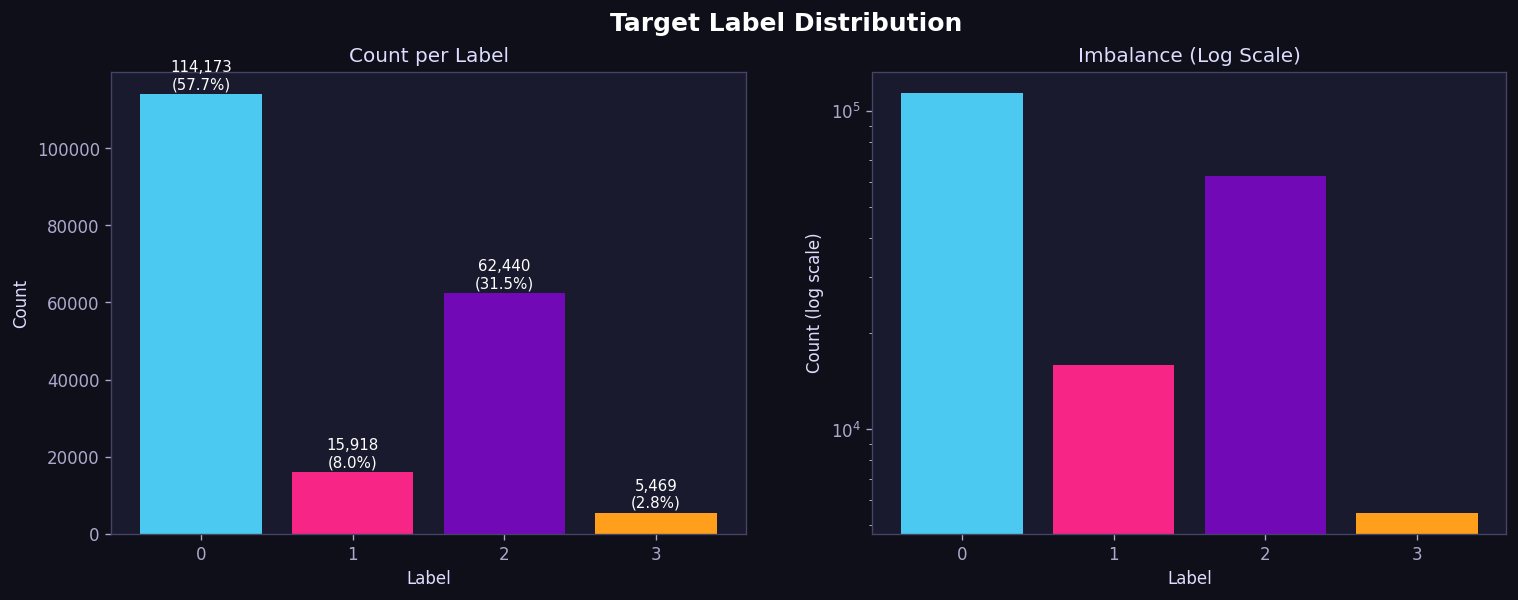

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Target Label Distribution', fontsize=15, color='white', fontweight='bold')

ax = axes[0]
bars = ax.bar(summary.index, summary['count'], color=PALETTE)
for bar, count, pct in zip(bars, summary['count'], summary['percentage']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
           f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9, color='white')
ax.set_xlabel('Label');
ax.set_ylabel('Count');
ax.set_title('Count per Label')
ax.set_xticks([0,1,2,3]);

ax = axes[1]
bars = ax.bar(summary.index, summary['count'], color=PALETTE)
ax.set_yscale('log')
ax.set_xlabel('Label');
ax.set_ylabel('Count (log scale)');
ax.set_title('Imbalance (Log Scale)')
ax.set_xticks([0,1,2,3]);


## 2. Missing Value Analysis

In [10]:
null_counts = train.isnull().sum()
null_pct = (train.isnull().mean()*100).round(2)

missing_train = pd.DataFrame({'Missing Count': null_counts, 'Missing %': null_pct})
missing_train = missing_train[missing_train['Missing Count']>0].sort_values('Missing Count', ascending=False)
display(missing_train)

,Missing Count,Missing %
race,145423,73.45
religion,145423,73.45
gender,145423,73.45
comment,1,0.00


#### Are missing demographics correlated with each other?

In [11]:
demo_cols = ['race', 'religion', 'gender']
race_nulls = train['race'].isnull()
religion_nulls = train['religion'].isnull()
gender_nulls = train['gender'].isnull()
print(f'\nAll three (race, religion, gender) simultaneously null: {(race_nulls & religion_nulls & gender_nulls).sum():,}')
print(f'Only race null but not others: {(race_nulls & -religion_nulls).sum()}')


All three (race, religion, gender) simultaneously null: 145,423
Only race null but not others: 0


- Missing values in race/religion/gender are perfectly co-occurring (same 145,423 rows)

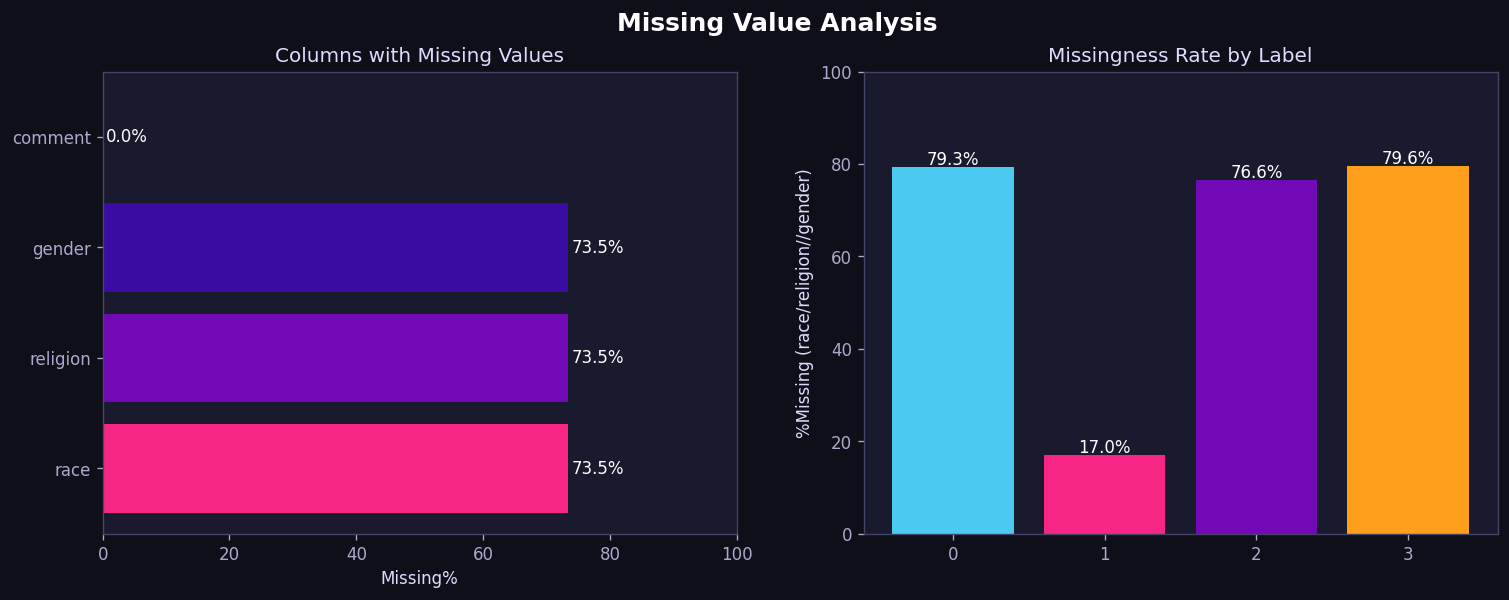

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Missing Value Analysis', fontsize=15, color='white', fontweight='bold')

ax = axes[0]
cols_with_missing = missing_train.index.tolist()
ax.barh(cols_with_missing, missing_train['Missing %'], 
        color=['#f72585', '#7209b7', '#3a0ca3', '#4cc9f0'][:len(cols_with_missing)])
for i, v in enumerate(missing_train['Missing %']):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10, color='white')
ax.set_xlabel('Missing%');
ax.set_title('Columns with Missing Values')
ax.set_xlim(0,100)

ax = axes[1]
miss_by_label = train.groupby('label')['race'].apply(lambda x: x.isnull().mean()*100)
ax.bar(miss_by_label.index, miss_by_label.values, color=PALETTE)
ax.set_xticks([0,1,2,3])
for i, v in enumerate(miss_by_label.values):
    ax.text(i, v+0.5, f'{v:.1f}%', ha='center', fontsize=10, color='white')
ax.set_ylabel('%Missing (race/religion//gender)');
ax.set_title('Missingness Rate by Label');
ax.set_ylim(0,100);

## 3. Numerical Features Statistics

In [13]:
num_cols = ['emoticon_1','emoticon_2','emoticon_3','upvote', 'downvote', 'if_1', 'if_2']

stats_table = pd.DataFrame(index=num_cols)
for col in num_cols:
    s = train[col]
    stats_table.loc[col, 'mean'] = s.mean()
    stats_table.loc[col, 'median'] = s.median()
    stats_table.loc[col, 'std'] = s.std()
    stats_table.loc[col, 'variance'] = s.var()
    stats_table.loc[col, 'min'] = s.min()
    stats_table.loc[col, 'max'] = s.max()
    stats_table.loc[col, 'Q1'] = s.quantile(0.25)
    stats_table.loc[col, 'Q3'] = s.quantile(0.75)
    stats_table.loc[col, 'IQR'] = s.quantile(0.75) - s.quantile(0.25)
    stats_table.loc[col, 'skewness'] = s.skew()
    stats_table.loc[col, 'kurtosis'] = s.kurtosis()
    stats_table.loc[col, 'zeros_%'] = (s==0).mean()*100

print('Custom Descriptive Statistics of Numerican Features:\n')
display(stats_table.round(3))

Custom Descriptive Statistics of Numerican Features:



,mean,median,std,variance,min,max,Q1,Q3,IQR,skewness,kurtosis,zeros_%
emoticon_1,0.280,0.0,1.023,1.047,0.0,47.0,0.0,0.0,0.0,9.980,201.319,85.393
emoticon_2,0.048,0.0,0.258,0.067,0.0,11.0,0.0,0.0,0.0,7.557,93.135,95.905
emoticon_3,0.121,0.0,0.481,0.231,0.0,17.0,0.0,0.0,0.0,7.060,87.218,91.331
upvote,2.608,1.0,5.055,25.551,0.0,201.0,0.0,3.0,3.0,7.103,111.180,39.985
downvote,0.666,0.0,2.044,4.179,0.0,107.0,0.0,1.0,1.0,10.062,219.682,74.564
if_1,1.906,0.0,25.636,657.192,0.0,1860.0,0.0,4.0,4.0,63.702,4158.635,73.446
if_2,7.956,6.0,14.839,220.210,3.0,1833.0,4.0,10.0,6.0,67.321,6872.758,0.000


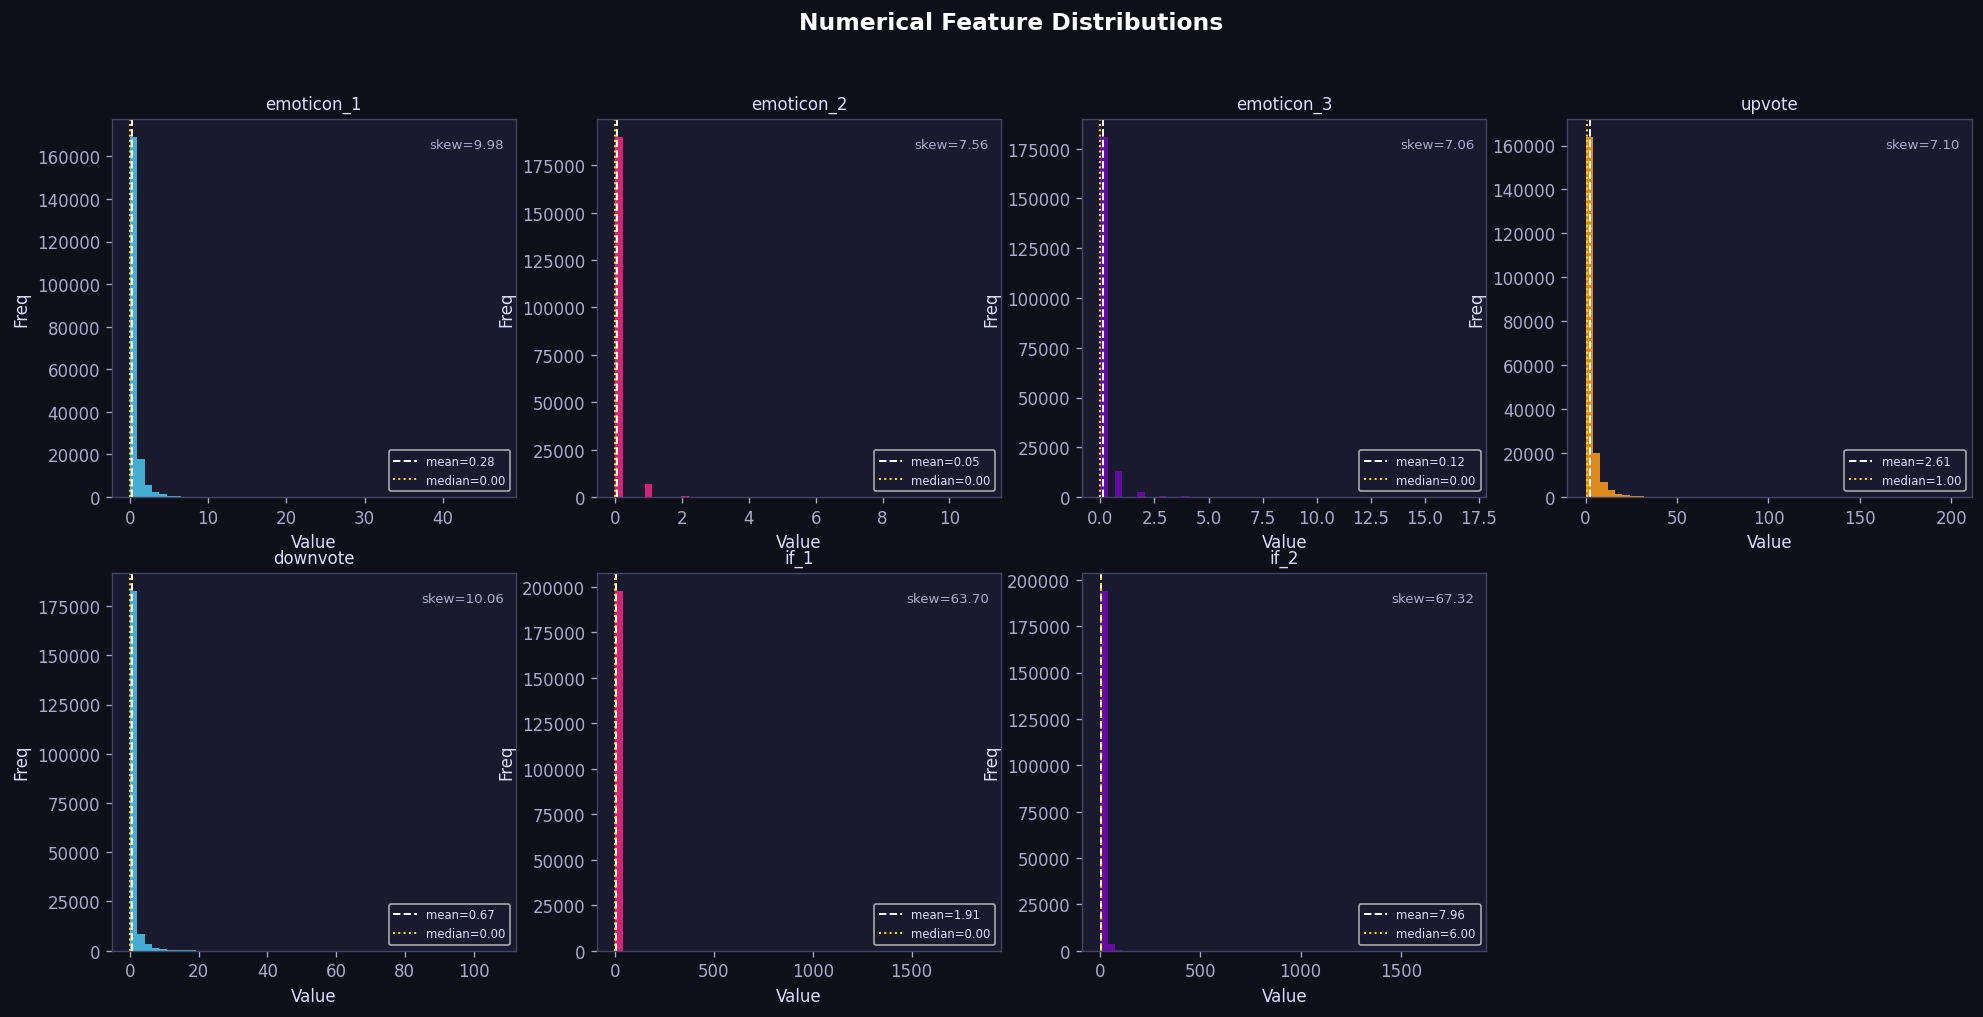

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes=axes.flatten()
fig.suptitle('Numerical Feature Distributions', fontsize=14, color='white', fontweight='bold');

for i, col in enumerate(num_cols):
    ax = axes[i]
    data = train[col]
    ax.hist(data, bins=50, color=PALETTE[i%4], edgecolor='none', alpha=0.85)
    ax.axvline(data.mean(), color='white', linestyle='--', linewidth=1.2, label=f'mean={data.mean():.2f}')
    ax.axvline(data.median(), color='#ffdd00', linestyle=':',  linewidth=1.2, label=f'median={data.median():.2f}')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('Value');
    ax.set_ylabel('Freq');
    ax.legend(fontsize=7)
    skw = skew(data)
    ax.text(0.97, 0.95, f'skew={skw:.2f}', transform=ax.transAxes,
           ha='right', va='top', fontsize=8, color='#aaaacc')

axes[-1].set_visible(False)

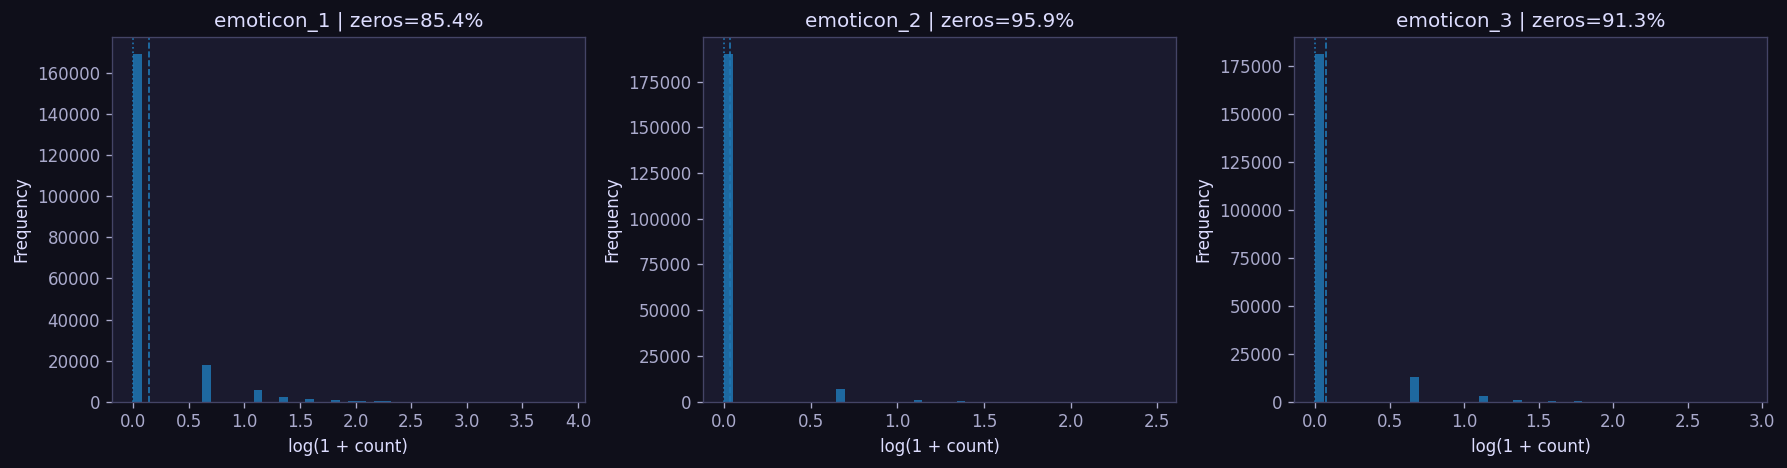

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

def plot_emoticon(data, col, ax):
    zero_pct = (data == 0).mean() * 100
    data_t = np.log1p(data)

    ax.hist(data_t, bins=50, alpha=0.85)
    ax.axvline(data_t.mean(), linestyle='--', linewidth=1)
    ax.axvline(np.median(data_t), linestyle=':', linewidth=1)

    ax.set_title(f"{col} | zeros={zero_pct:.1f}%")
    ax.set_xlabel("log(1 + count)")
    ax.set_ylabel("Frequency")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_emoticon(train['emoticon_1'], 'emoticon_1', axes[0])
plot_emoticon(train['emoticon_2'], 'emoticon_2', axes[1])
plot_emoticon(train['emoticon_3'], 'emoticon_3', axes[2])

plt.tight_layout()
plt.show()

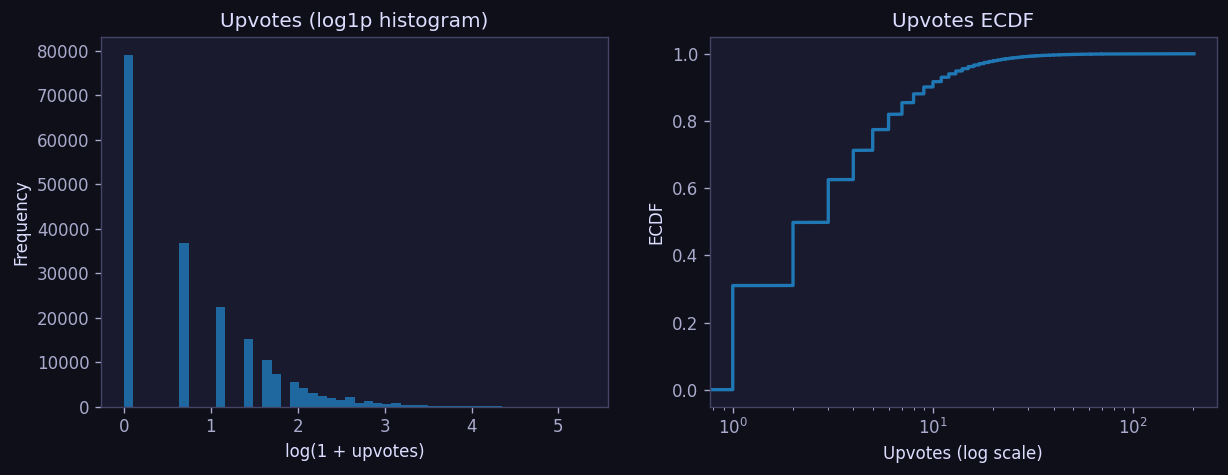

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

def plot_upvote_hist(data, ax):
    data_t = np.log1p(data)
    ax.hist(data_t, bins=50, alpha=0.85)
    ax.set_xlabel("log(1 + upvotes)")
    ax.set_ylabel("Frequency")
    ax.set_title("Upvotes (log1p histogram)")

def plot_upvote_ectrain(data, ax):
    ecdf = ECDF(data[data > 0])
    ax.plot(ecdf.x, ecdf.y, linewidth=2)
    ax.set_xscale('log')
    ax.set_xlabel("Upvotes (log scale)")
    ax.set_ylabel("ECDF")
    ax.set_title("Upvotes ECDF")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_upvote_hist(train['upvote'], axes[0])
plot_upvote_ectrain(train['upvote'], axes[1])


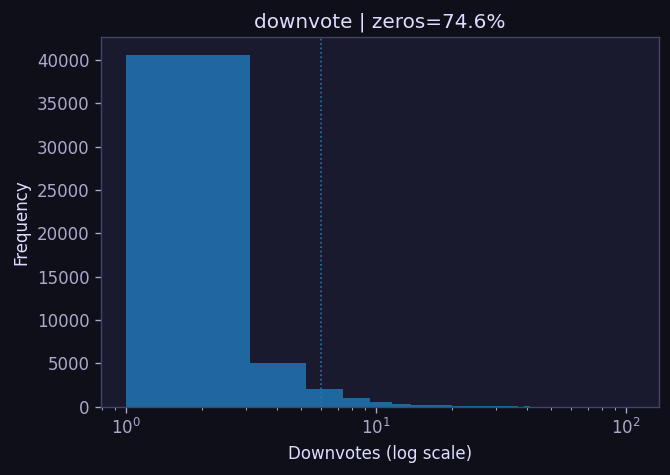

In [17]:
def plot_downvote(data, col, ax):
    zero_pct = (data == 0).mean() * 100
    nz = data[data > 0]

    ax.hist(nz, bins=50, alpha=0.85)
    ax.set_xscale('log')

    ax.set_title(f"{col} | zeros={zero_pct:.1f}%")
    ax.set_xlabel("Downvotes (log scale)")
    ax.set_ylabel("Frequency")

nz = data[data > 0]
fig, ax = plt.subplots(figsize=(6, 4))
ax.axvline(np.median(nz), linestyle=':', linewidth=1)
plot_downvote(train['downvote'], 'downvote', ax)


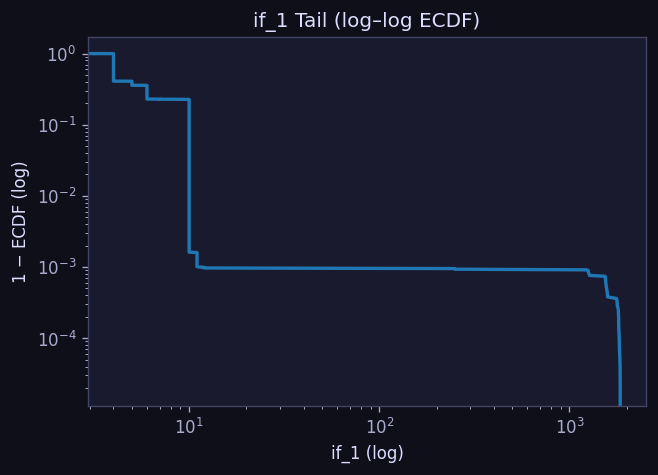

In [18]:
def plot_if1_loglog_ecdf(data, ax):
    nz = data[data > 0]

    if len(nz) == 0:
        ax.text(0.5, 0.5, "No non-zero values",
                transform=ax.transAxes,
                ha='center', va='center')
        ax.set_axis_off()
        return

    ecdf = ECDF(nz)

    ax.plot(ecdf.x, 1 - ecdf.y, linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel("if_1 (log)")
    ax.set_ylabel("1 − ECDF (log)")
    ax.set_title("if_1 Tail (log–log ECDF)")

import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

fig, ax = plt.subplots(figsize=(6, 4))
plot_if1_loglog_ecdf(train['if_1'], ax)


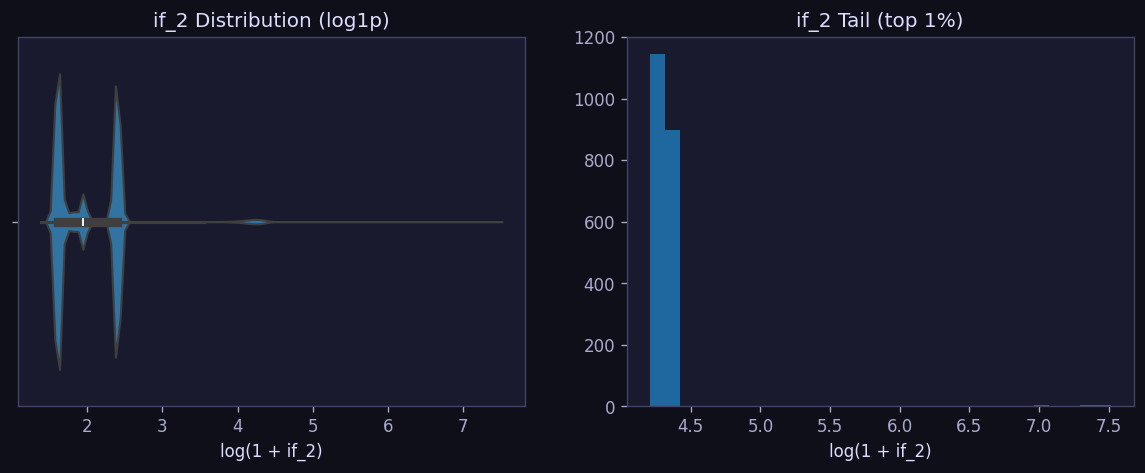

In [19]:
def plot_if2_violin(data, ax):
    data_t = np.log1p(data)
    sns.violinplot(x=data_t, ax=ax, cut=0)
    ax.set_xlabel("log(1 + if_2)")
    ax.set_title("if_2 Distribution (log1p)")

def plot_if2_tail(data, ax, q=0.99):
    tail = data[data >= data.quantile(q)]
    ax.hist(np.log1p(tail), bins=30, alpha=0.85)
    ax.set_xlabel("log(1 + if_2)")
    ax.set_title(f"if_2 Tail (top {(1-q)*100:.0f}%)")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_if2_violin(train['if_2'], axes[0])
plot_if2_tail(train['if_2'], axes[1], q=0.99)


Kruskal-Wallis significance: *** p<0.001  ** p<0.01  * p<0.05  ns=not significant


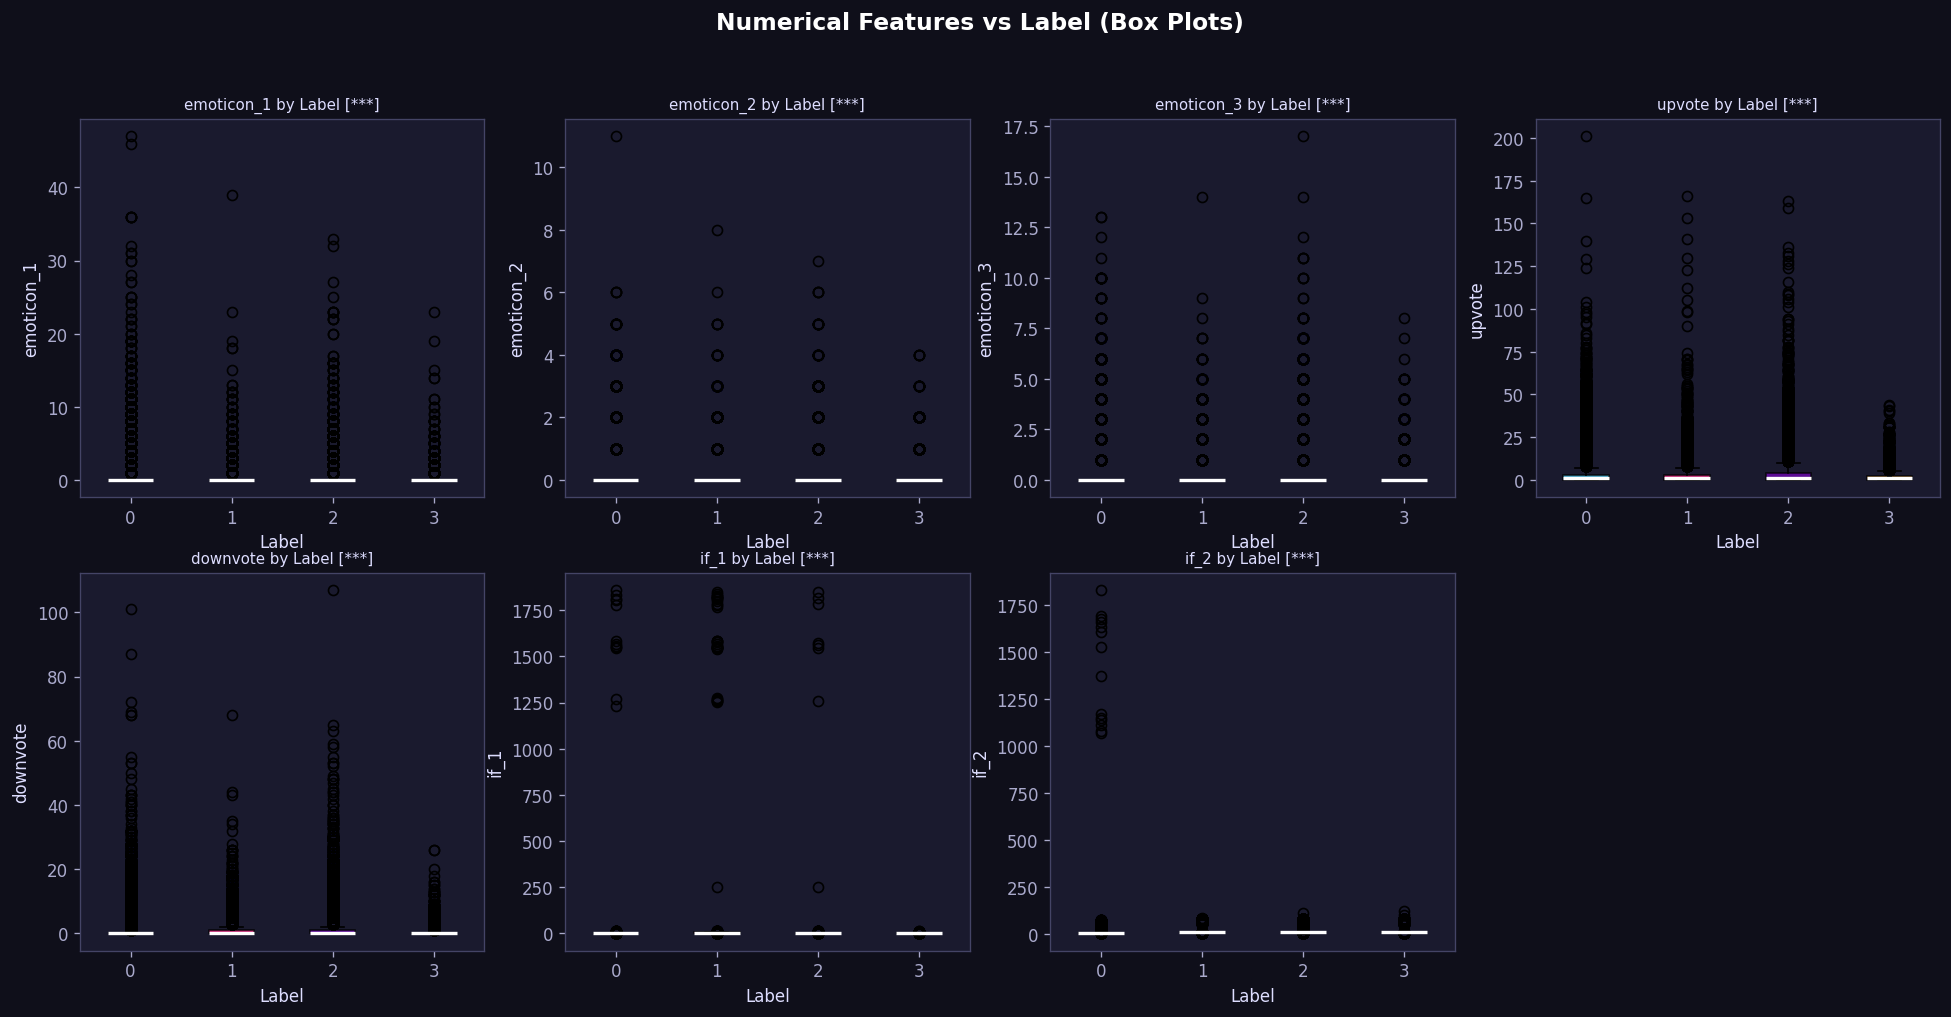

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()
fig.suptitle('Numerical Features vs Label (Box Plots)', fontsize=14, color='white', fontweight='bold')

for i, col in enumerate(num_cols):
    ax = axes[i]
    data_by_label = [train[train['label'] == lbl][col].values for lbl in sorted(train['label'].unique())]
    bp = ax.boxplot(data_by_label, patch_artist=True, notch=False,
                   medianprops=dict(color='white', linewidth=2))
    for patch, color in zip(bp['boxes'], PALETTE):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    ax.set_xticklabels([str(l) for l in sorted(train['label'].unique())])
    ax.set_xlabel('Label');
    ax.set_ylabel(col)
    ax.set_title(f'{col} by Label', fontsize=9)

    stat, p = kruskal(*data_by_label)
    sig = '***' if p<0.001 else ('**' if p < 0.01 else ('*' if p<0.05 else 'ns'))
    ax.set_title(f'{col} by Label [{sig}]', fontsize=9)

axes[-1].set_visible(False)
print('Kruskal-Wallis significance: *** p<0.001  ** p<0.01  * p<0.05  ns=not significant')

## 4. Categorical Feature Analysis

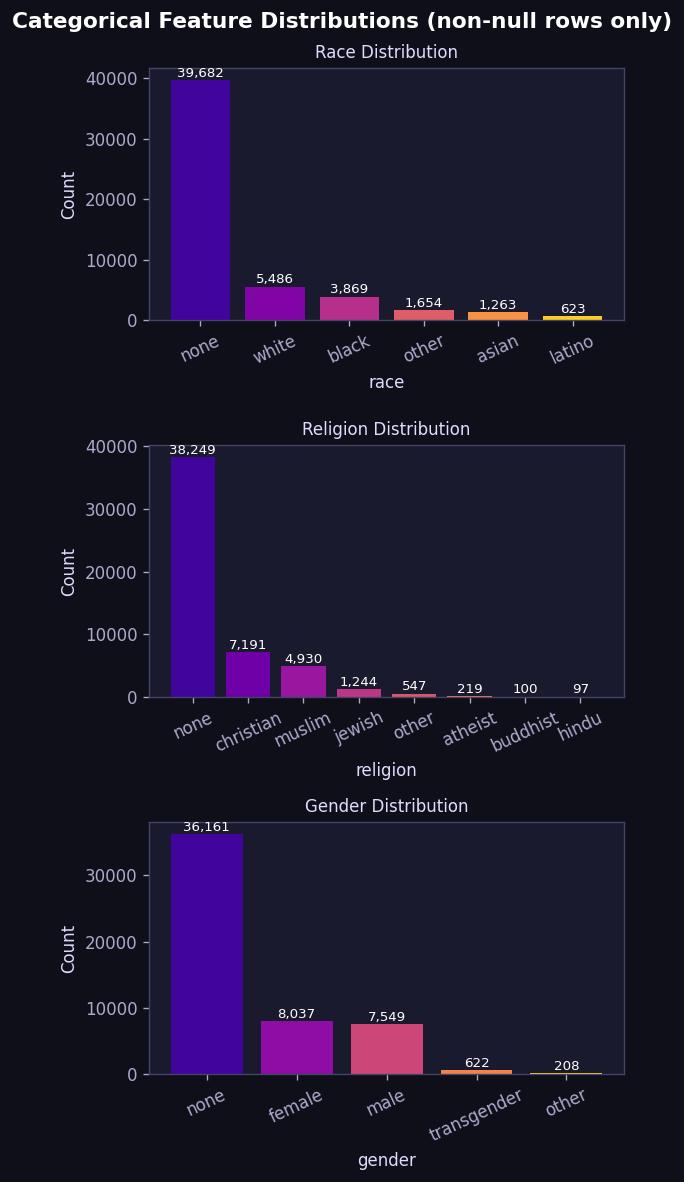

In [21]:
cat_cols = ['race', 'religion', 'gender']

fig, axes = plt.subplots(3, 1, figsize=(5, 10))
fig.suptitle('Categorical Feature Distributions (non-null rows only)', fontsize=13, color='white', fontweight='bold')

for ax, col in zip(axes, cat_cols):
    vc = train[col].value_counts()
    colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(vc)))
    bars = ax.bar(vc.index, vc.values, color=colors)
    for bar, v in zip(bars, vc.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{v:,}', ha='center', va='bottom', fontsize=8, color='white')
    ax.set_title(f'{col.capitalize()} Distribution', fontsize=10)
    ax.set_xlabel(col); ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=25)

plt.tight_layout(); plt.show()

In [22]:
# Chi-square tests: categorical features vs label (using filled column)
train['race_filled']     = train['race'].fillna('none')
train['religion_filled'] = train['religion'].fillna('none')
train['gender_filled']   = train['gender'].fillna('none')

print('==== Chi-Square Tests: Categorical Feature vs Label ====')
for col in ['race_filled', 'religion_filled', 'gender_filled', 'disability']:
    ct = pd.crosstab(train[col], train['label'])
    chi2, p, dof, expected = chi2_contingency(ct)
    
    # Cramér's V
    n = ct.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(ct.shape) - 1)))
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
    print(f'{col:20s}  χ²={chi2:.1f}  dof={dof}  p={p:.2e}  {sig}  Cramér\'s V={cramers_v:.4f}')

print('\nCramér\'s V: 0–0.1=negligible, 0.1–0.3=small, 0.3–0.5=moderate, >0.5=large')

==== Chi-Square Tests: Categorical Feature vs Label ====
race_filled           χ²=45429.2  dof=15  p=0.00e+00  ***  Cramér's V=0.2766
religion_filled       χ²=32056.8  dof=21  p=0.00e+00  ***  Cramér's V=0.2323
gender_filled         χ²=10202.0  dof=12  p=0.00e+00  ***  Cramér's V=0.1311
disability            χ²=857.6  dof=3  p=1.42e-185  ***  Cramér's V=0.0658

Cramér's V: 0–0.1=negligible, 0.1–0.3=small, 0.3–0.5=moderate, >0.5=large


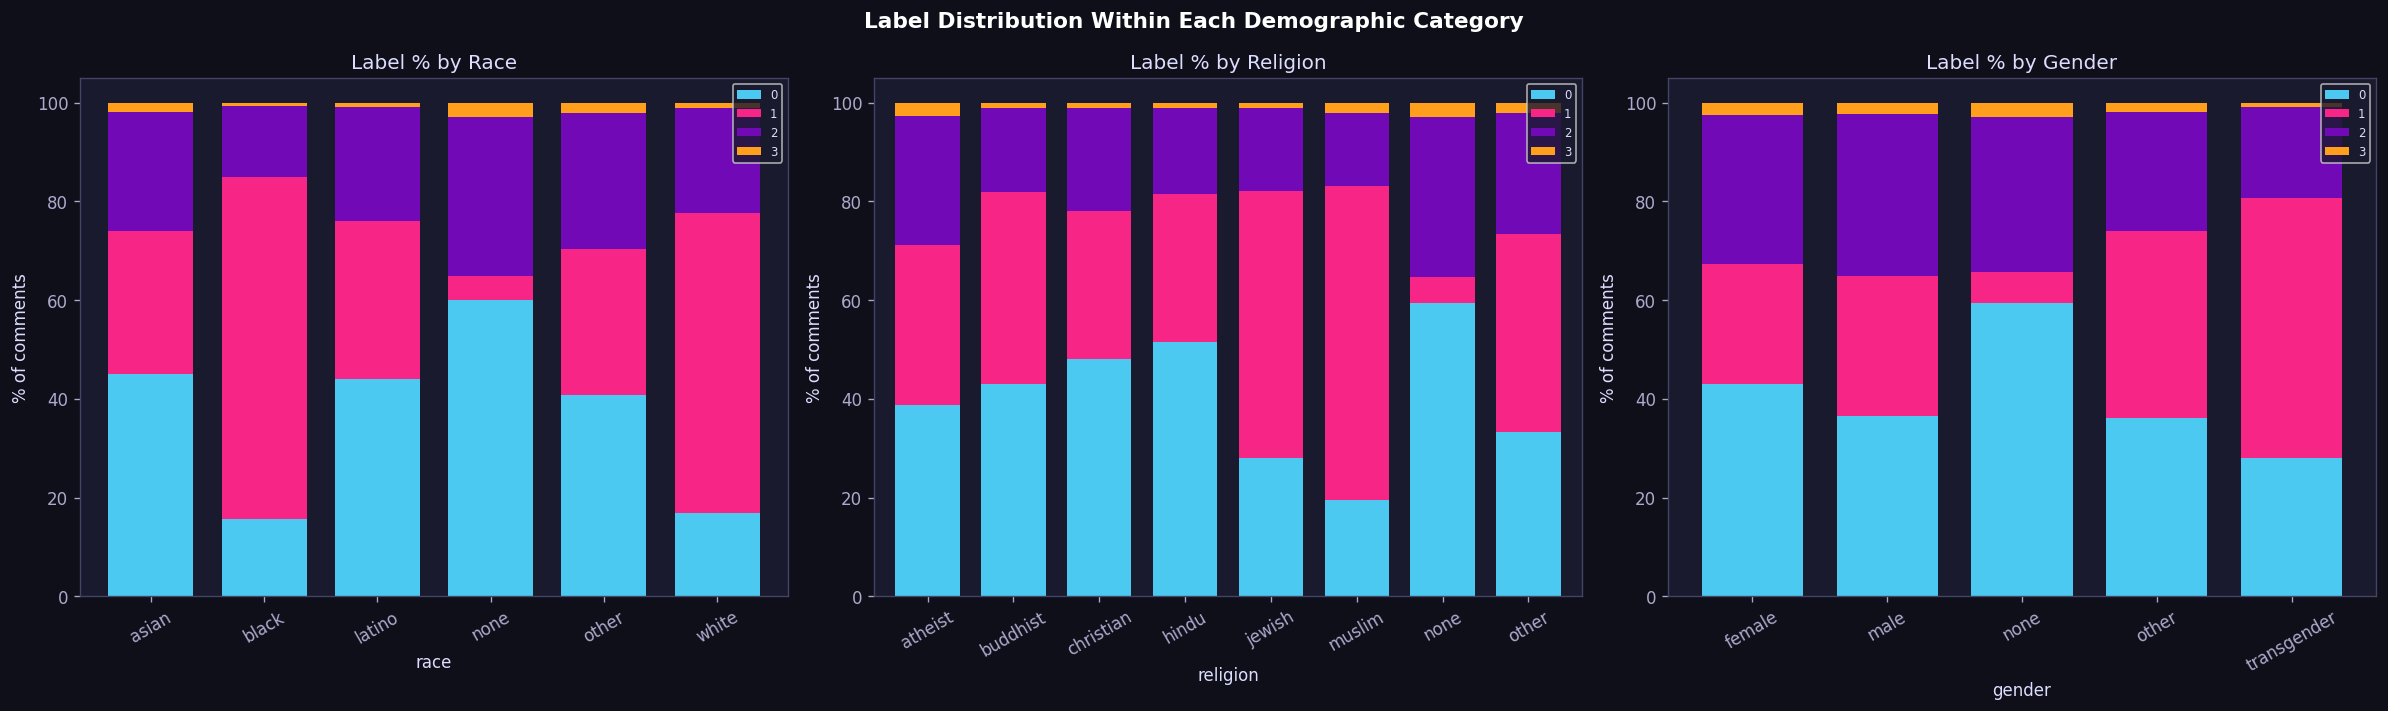

In [23]:
# Stacked bar: label distribution within each category
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Label Distribution Within Each Demographic Category', fontsize=13, color='white', fontweight='bold')

for ax, col in zip(axes, ['race_filled', 'religion_filled', 'gender_filled']):
    ct = pd.crosstab(train[col], train['label'], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, ax=ax, color=PALETTE, edgecolor='none', width=0.75)
    ax.set_xlabel(col.replace('_filled', '')); ax.set_ylabel('% of comments')
    ax.set_title(f'Label % by {col.replace("_filled", "").capitalize()}')
    ax.legend([0,1,2,3], fontsize=7, loc='upper right')
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout(); plt.show()

## 5. Text Feature Analysis (Comment)

In [24]:
# ── Compute text statistics ────────────────────────────────────────────────────
train['comment_clean'] = train['comment'].fillna('')
train['char_len']      = train['comment_clean'].str.len()
train['word_count']    = train['comment_clean'].str.split().str.len()
train['sentence_count']= train['comment_clean'].str.count(r'[.!?]+') + 1
train['avg_word_len']  = train['comment_clean'].apply(
    lambda t: np.mean([len(w) for w in t.split()]) if t.split() else 0
)
train['unique_words']  = train['comment_clean'].apply(lambda t: len(set(t.lower().split())))
train['lexical_diversity'] = train.apply(
    lambda r: r['unique_words'] / r['word_count'] if r['word_count'] > 0 else 0, axis=1
)
train['exclamation']   = train['comment_clean'].str.count('!')
train['question']      = train['comment_clean'].str.count(r'\?')
train['uppercase_ratio'] = train['comment_clean'].apply(
    lambda t: sum(1 for c in t if c.isupper()) / max(len(t), 1)
)

text_metrics = ['char_len', 'word_count', 'avg_word_len', 'sentence_count',
                'lexical_diversity', 'exclamation', 'question', 'uppercase_ratio']

# Overall stats
text_stats = pd.DataFrame(index=text_metrics)
for m in text_metrics:
    s = train[m]
    text_stats.loc[m, 'mean']     = s.mean()
    text_stats.loc[m, 'median']   = s.median()
    text_stats.loc[m, 'std']      = s.std()
    text_stats.loc[m, 'min']      = s.min()
    text_stats.loc[m, 'max']      = s.max()
    text_stats.loc[m, 'skewness'] = skew(s.dropna())

print('==== Text Feature Statistics ====')
display(text_stats.round(3))

==== Text Feature Statistics ====


,mean,median,std,min,max,skewness
char_len,302.909,211.000,266.442,0.0,1892.0,1.226
word_count,52.397,37.000,45.770,0.0,315.0,1.231
avg_word_len,4.908,4.714,2.804,0.0,333.0,42.181
sentence_count,4.751,4.000,3.233,1.0,57.0,1.789
lexical_diversity,0.869,0.878,0.106,0.0,1.0,-0.425
exclamation,0.224,0.000,0.952,0.0,96.0,23.076
question,0.440,0.000,0.992,0.0,49.0,5.653
uppercase_ratio,0.036,0.027,0.043,0.0,1.0,9.883


In [25]:
# Text stats broken down by label
text_by_label = train.groupby('label')[text_metrics].agg(['mean', 'median', 'std'])
print('==== Text Statistics by Label ====')
display(text_by_label.round(3))

==== Text Statistics by Label ====


char_len                 word_count                avg_word_len         \
          mean median      std       mean median     std         mean median   
label                                                                          
0      295.897  199.0  269.586     51.187   35.0  46.289        4.962  4.700   
1      335.710  246.0  267.544     57.233   42.0  45.506        4.933  4.818   
2      316.893  232.0  262.830     54.902   40.0  45.303        4.835  4.734   
3      194.172  128.0  194.253     34.978   24.0  34.361        4.561  4.500   

             sentence_count  ... lexical_diversity exclamation                \
         std           mean  ...               std        mean median    std   
label                        ...                                               
0      3.567          4.638  ...             0.108       0.198    0.0  0.860   
1      1.232          5.006  ...             0.106       0.196    0.0  0.796   
2      1.096          4.977  ...             0.102       0.275    0.0  1.135   
3      0.747          3.772  ...             0.096       0.260    0.0  0.893   

      question               uppercase_ratio                
          mean median    std            mean median    std  
label                                                       
0        0.425    0.0  0.948           0.036  0.027  0.044  
1        0.544    0.0  1.098           0.035  0.028  0.042  
2        0.450    0.0  1.054           0.034  0.027  0.040  
3        0.336    0.0  0.798           0.037  0.026  0.049  

[4 rows x 24 columns]

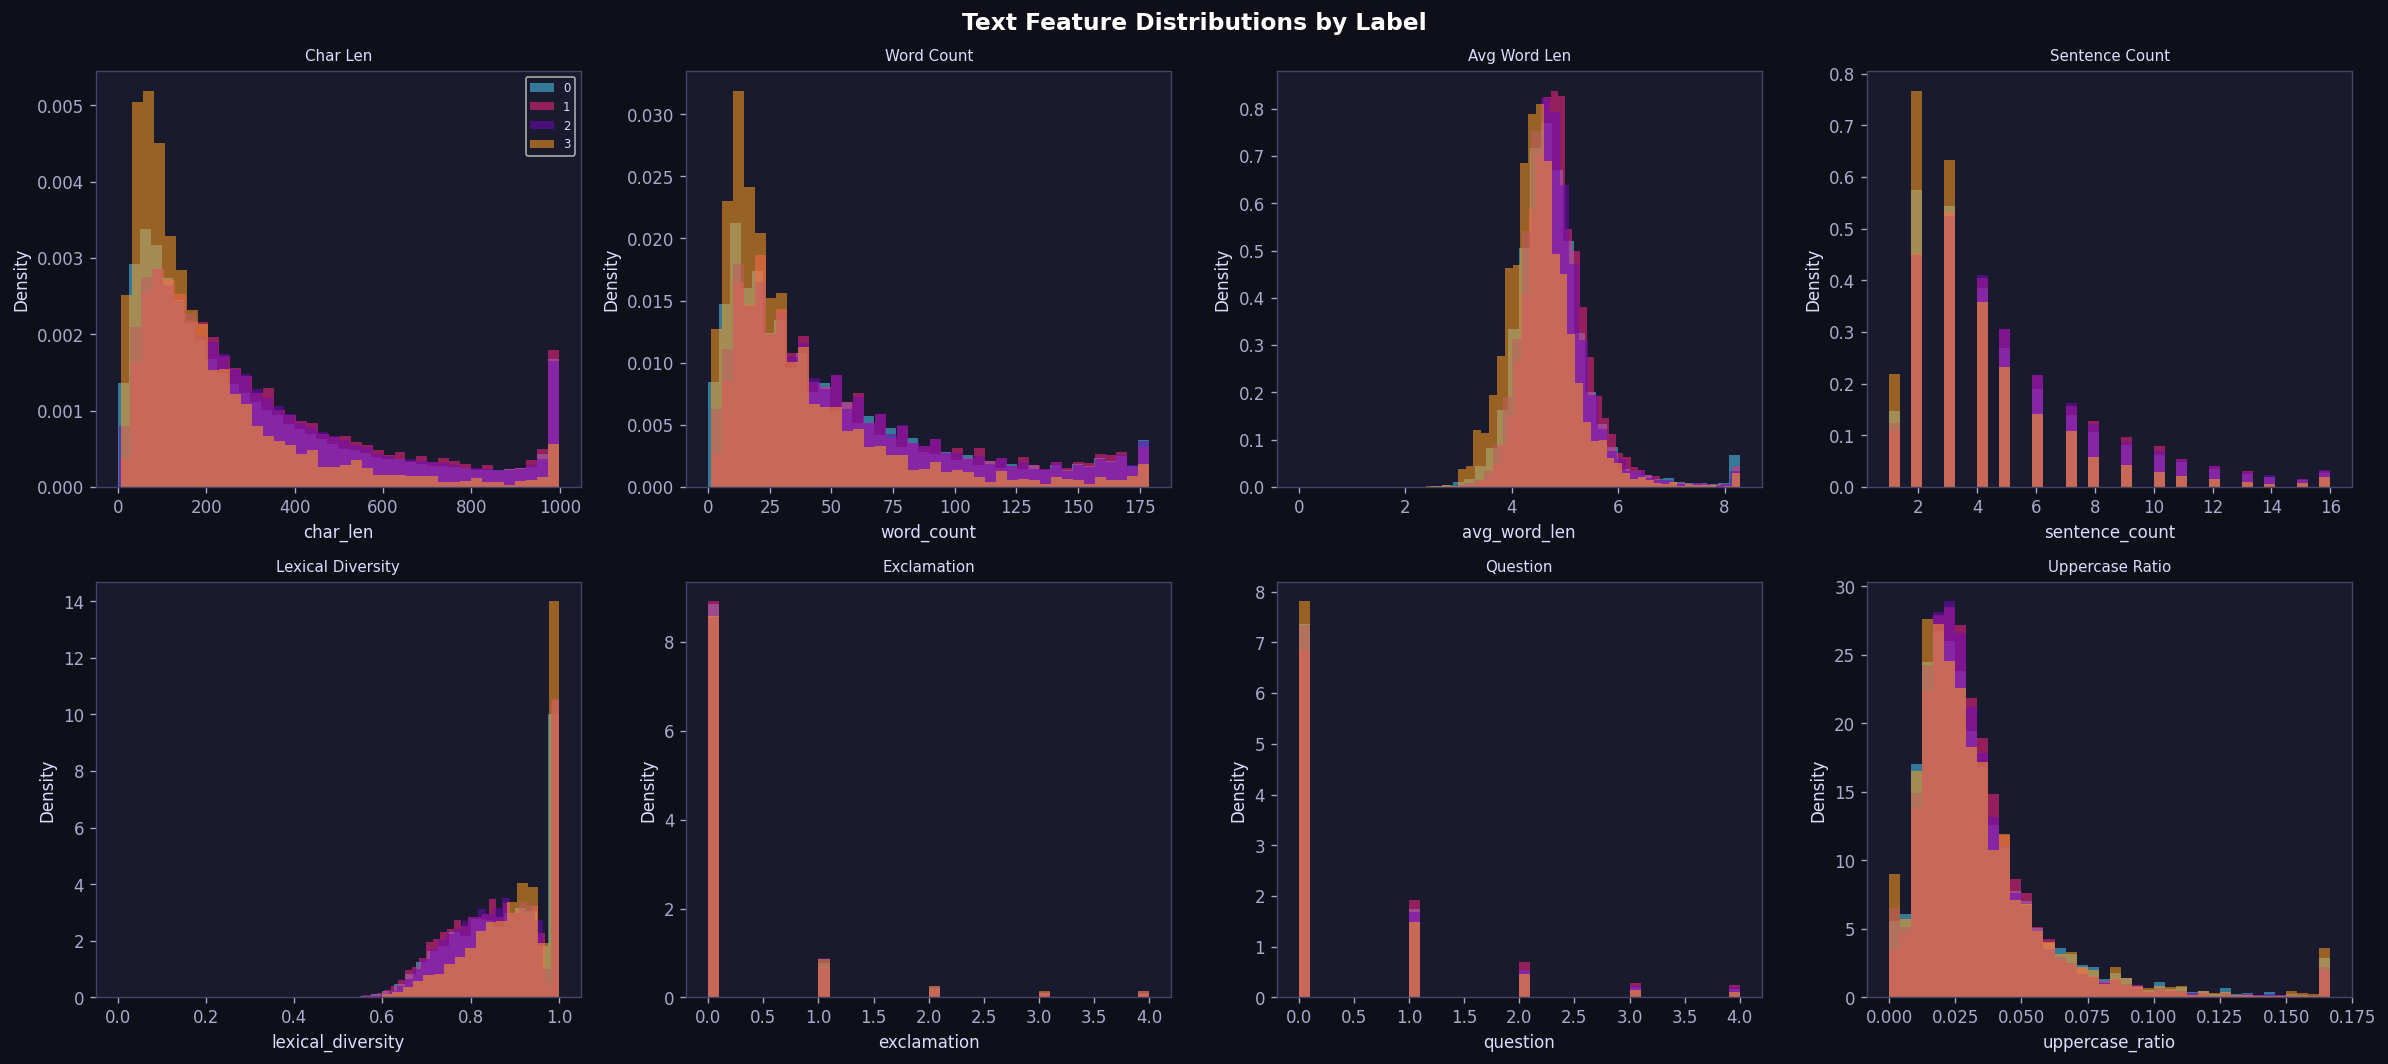

In [26]:
fig, axes = plt.subplots(2, 4, figsize=(20, 9))
axes = axes.flatten()
fig.suptitle('Text Feature Distributions by Label', fontsize=14, color='white', fontweight='bold')

for i, metric in enumerate(text_metrics):
    ax = axes[i]
    for lbl, color in zip(sorted(train['label'].unique()), PALETTE):
        subset = train[train['label'] == lbl][metric].clip(upper=train[metric].quantile(0.99))
        ax.hist(subset, bins=40, alpha=0.55, color=color, label=lbl, density=True)
    ax.set_title(metric.replace('_', ' ').title(), fontsize=9)
    ax.set_xlabel(metric); ax.set_ylabel('Density')
    if i == 0:
        ax.legend(fontsize=7)

plt.tight_layout(); plt.show()

In [27]:
# Statistical tests: Kruskal-Wallis + effect size (η²)
print('==== Kruskal-Wallis Tests: Text Metrics vs Label ====')
groups = [train[train['label'] == lbl] for lbl in sorted(train['label'].unique())]
results = []
for m in text_metrics:
    g = [grp[m].dropna().values for grp in groups]
    stat, p = kruskal(*g)
    # Eta-squared approximation
    N = sum(len(gi) for gi in g)
    k = len(g)
    eta2 = (stat - k + 1) / (N - k)
    results.append({'metric': m, 'H-stat': stat, 'p-value': p,
                    'sig': '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')),
                    'eta² (effect)': max(eta2, 0)})

res_train = pd.DataFrame(results).set_index('metric')
display(res_train.round(4))

==== Kruskal-Wallis Tests: Text Metrics vs Label ====


,H-stat,p-value,sig,eta² (effect)
metric,,,,
char_len,2347.6213,0.0,***,0.0118
word_count,2048.5860,0.0,***,0.0103
avg_word_len,1691.8354,0.0,***,0.0085
sentence_count,1555.0738,0.0,***,0.0078
lexical_diversity,1158.1186,0.0,***,0.0058
exclamation,348.9171,0.0,***,0.0017
question,287.7430,0.0,***,0.0014
uppercase_ratio,89.3394,0.0,***,0.0004


## 6. Feature Correlation Analysis

### Pearson Correlation

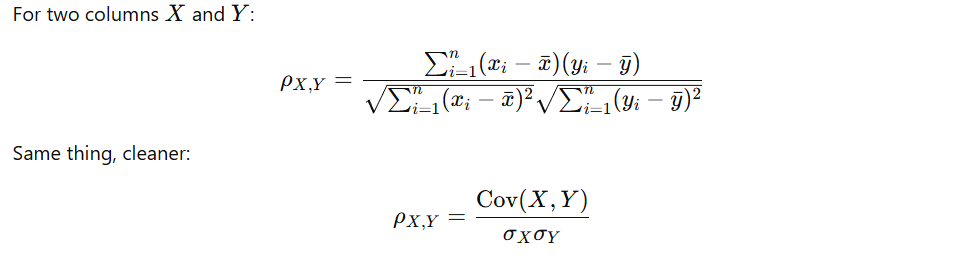

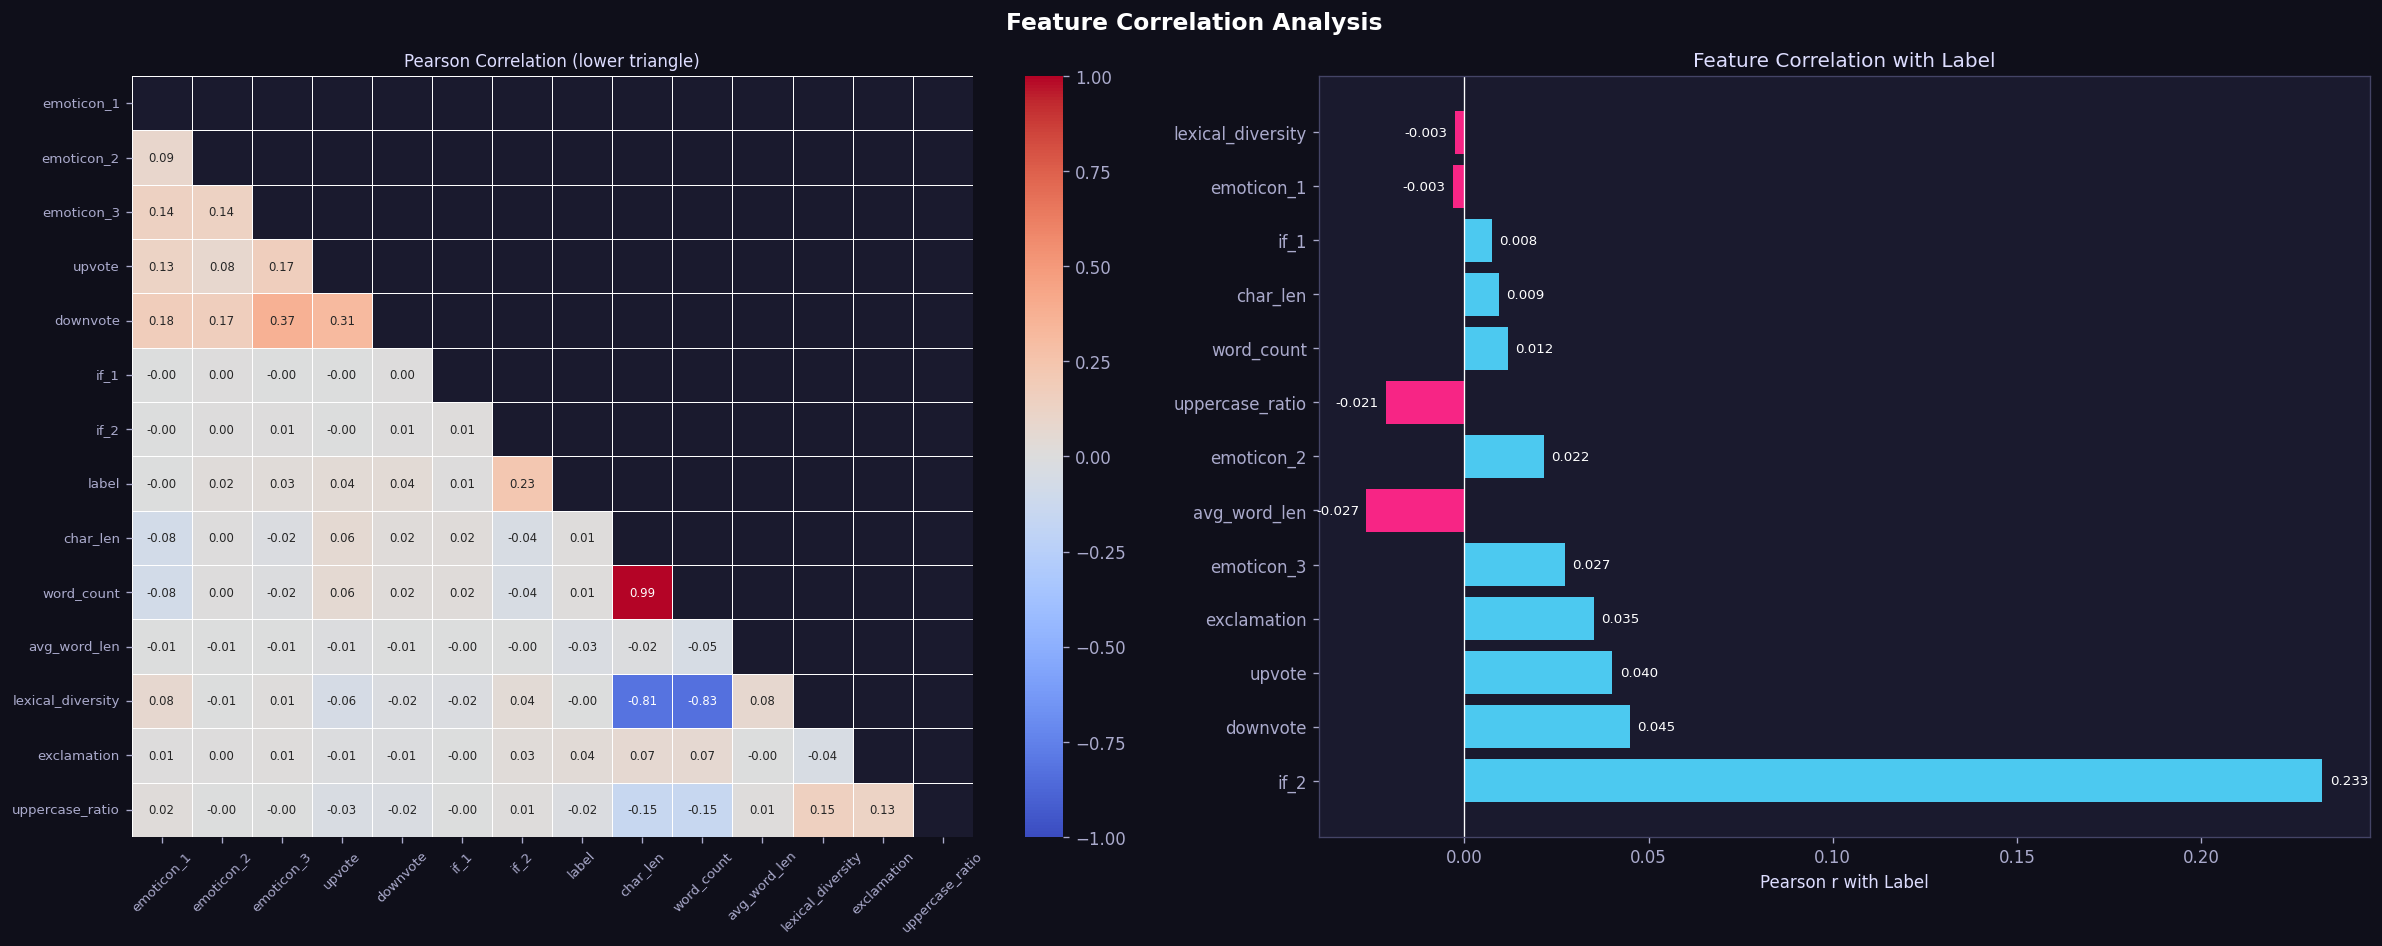

In [28]:
corr_cols = num_cols + ['label', 'char_len', 'word_count', 'avg_word_len',
                        'lexical_diversity', 'exclamation', 'uppercase_ratio']

corr_matrix = train[corr_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Feature Correlation Analysis', fontsize=14, color='white', fontweight='bold')

# Pearson heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, ax=axes[0], mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, linewidths=0.3,
            annot_kws={'size': 7}, vmin=-1, vmax=1)
axes[0].set_title('Pearson Correlation (lower triangle)', fontsize=10)
axes[0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)

# Correlation with 'label' specifically
label_corr = corr_matrix['label'].drop('label').sort_values(key=abs, ascending=False)
colors = ['#f72585' if v < 0 else '#4cc9f0' for v in label_corr]
axes[1].barh(label_corr.index, label_corr.values, color=colors)
axes[1].axvline(0, color='white', linewidth=0.8)
axes[1].set_xlabel('Pearson r with Label'); axes[1].set_title('Feature Correlation with Label')
for i, v in enumerate(label_corr.values):
    axes[1].text(v + (0.002 if v >= 0 else -0.002), i, f'{v:.3f}',
                 va='center', ha='left' if v >= 0 else 'right', fontsize=8, color='white')

plt.tight_layout(); plt.show()

In [29]:
# Spearman correlation (rank-based, better for skewed distributions)
spearman_corr = train[corr_cols].corr(method='spearman')
label_spearman = spearman_corr['label'].drop('label').sort_values(key=abs, ascending=False)

print('==== Pearson vs Spearman Correlation with Label ====')
comparison = pd.DataFrame({
    'Pearson r': label_corr.reindex(label_spearman.index),
    'Spearman ρ': label_spearman
})
display(comparison.round(4))

==== Pearson vs Spearman Correlation with Label ====


,Pearson r,Spearman ρ
if_2,0.2329,0.8316
if_1,0.0075,0.0799
downvote,0.0449,0.0627
word_count,0.0117,0.0407
char_len,0.0094,0.0398
upvote,0.0402,0.0385
exclamation,0.0352,0.0370
emoticon_3,0.0273,0.0324
emoticon_2,0.0216,0.0233
uppercase_ratio,-0.0214,-0.0167


## 7. Temporal Analysis

In [30]:
train['created_date'] = pd.to_datetime(train['created_date'])

# Parse date parts
train['year']       = train['created_date'].dt.year
train['month']      = train['created_date'].dt.month
train['dayofweek']  = train['created_date'].dt.dayofweek  # 0=Mon
train['hour']       = train['created_date'].dt.hour

print('Date range:', train['created_date'].min(), '->', train['created_date'].max())
print('Year distribution:')
display(train['year'].value_counts().sort_index())

Date range: 2022-04-29 14:50:48.488476+00:00 -> 2024-06-11 04:41:08.821674+00:00
Year distribution:


year
2022      7517
2023    100405
2024     90078
Name: count, dtype: int64

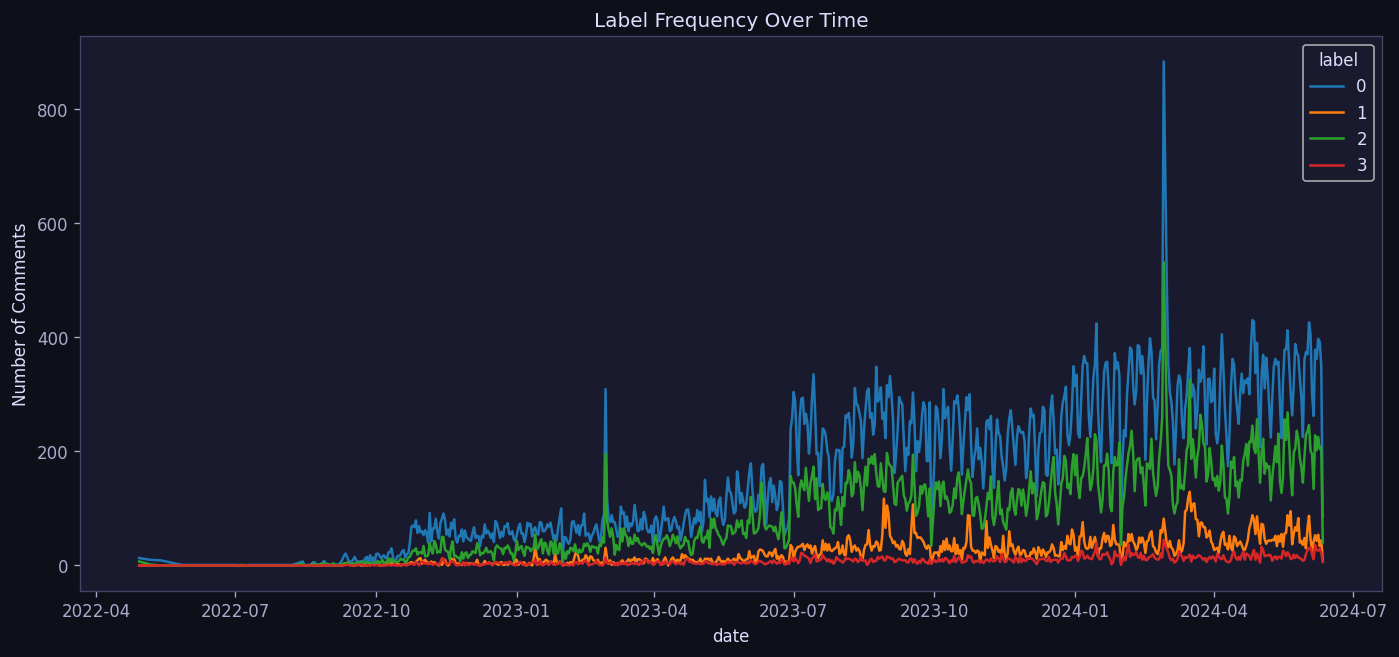

In [31]:
train['date'] = train['created_date'].dt.date

daily = train.groupby(['date', 'label']).size().unstack().fillna(0)

daily.plot(figsize=(14,6))
plt.title("Label Frequency Over Time")
plt.ylabel("Number of Comments")
plt.show()

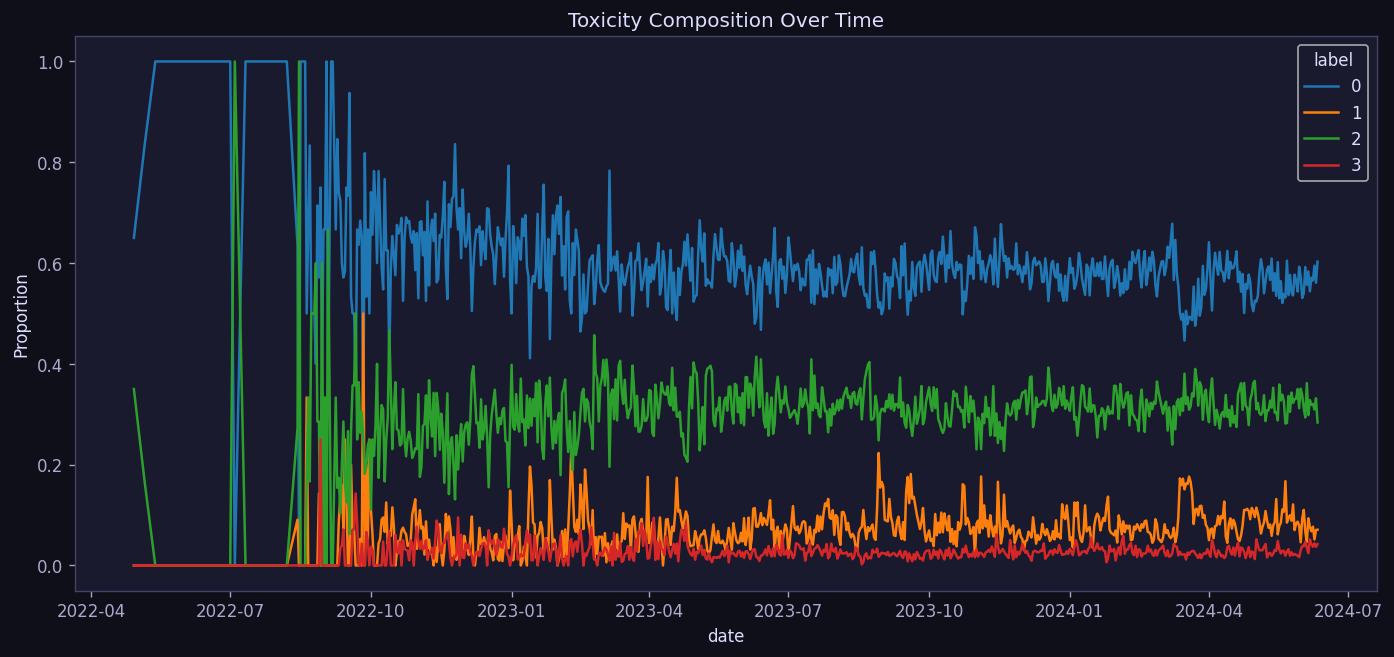

In [32]:
prop = daily.div(daily.sum(axis=1), axis=0)
prop.plot(figsize=(14,6))
plt.title("Toxicity Composition Over Time")
plt.ylabel("Proportion")
plt.show()

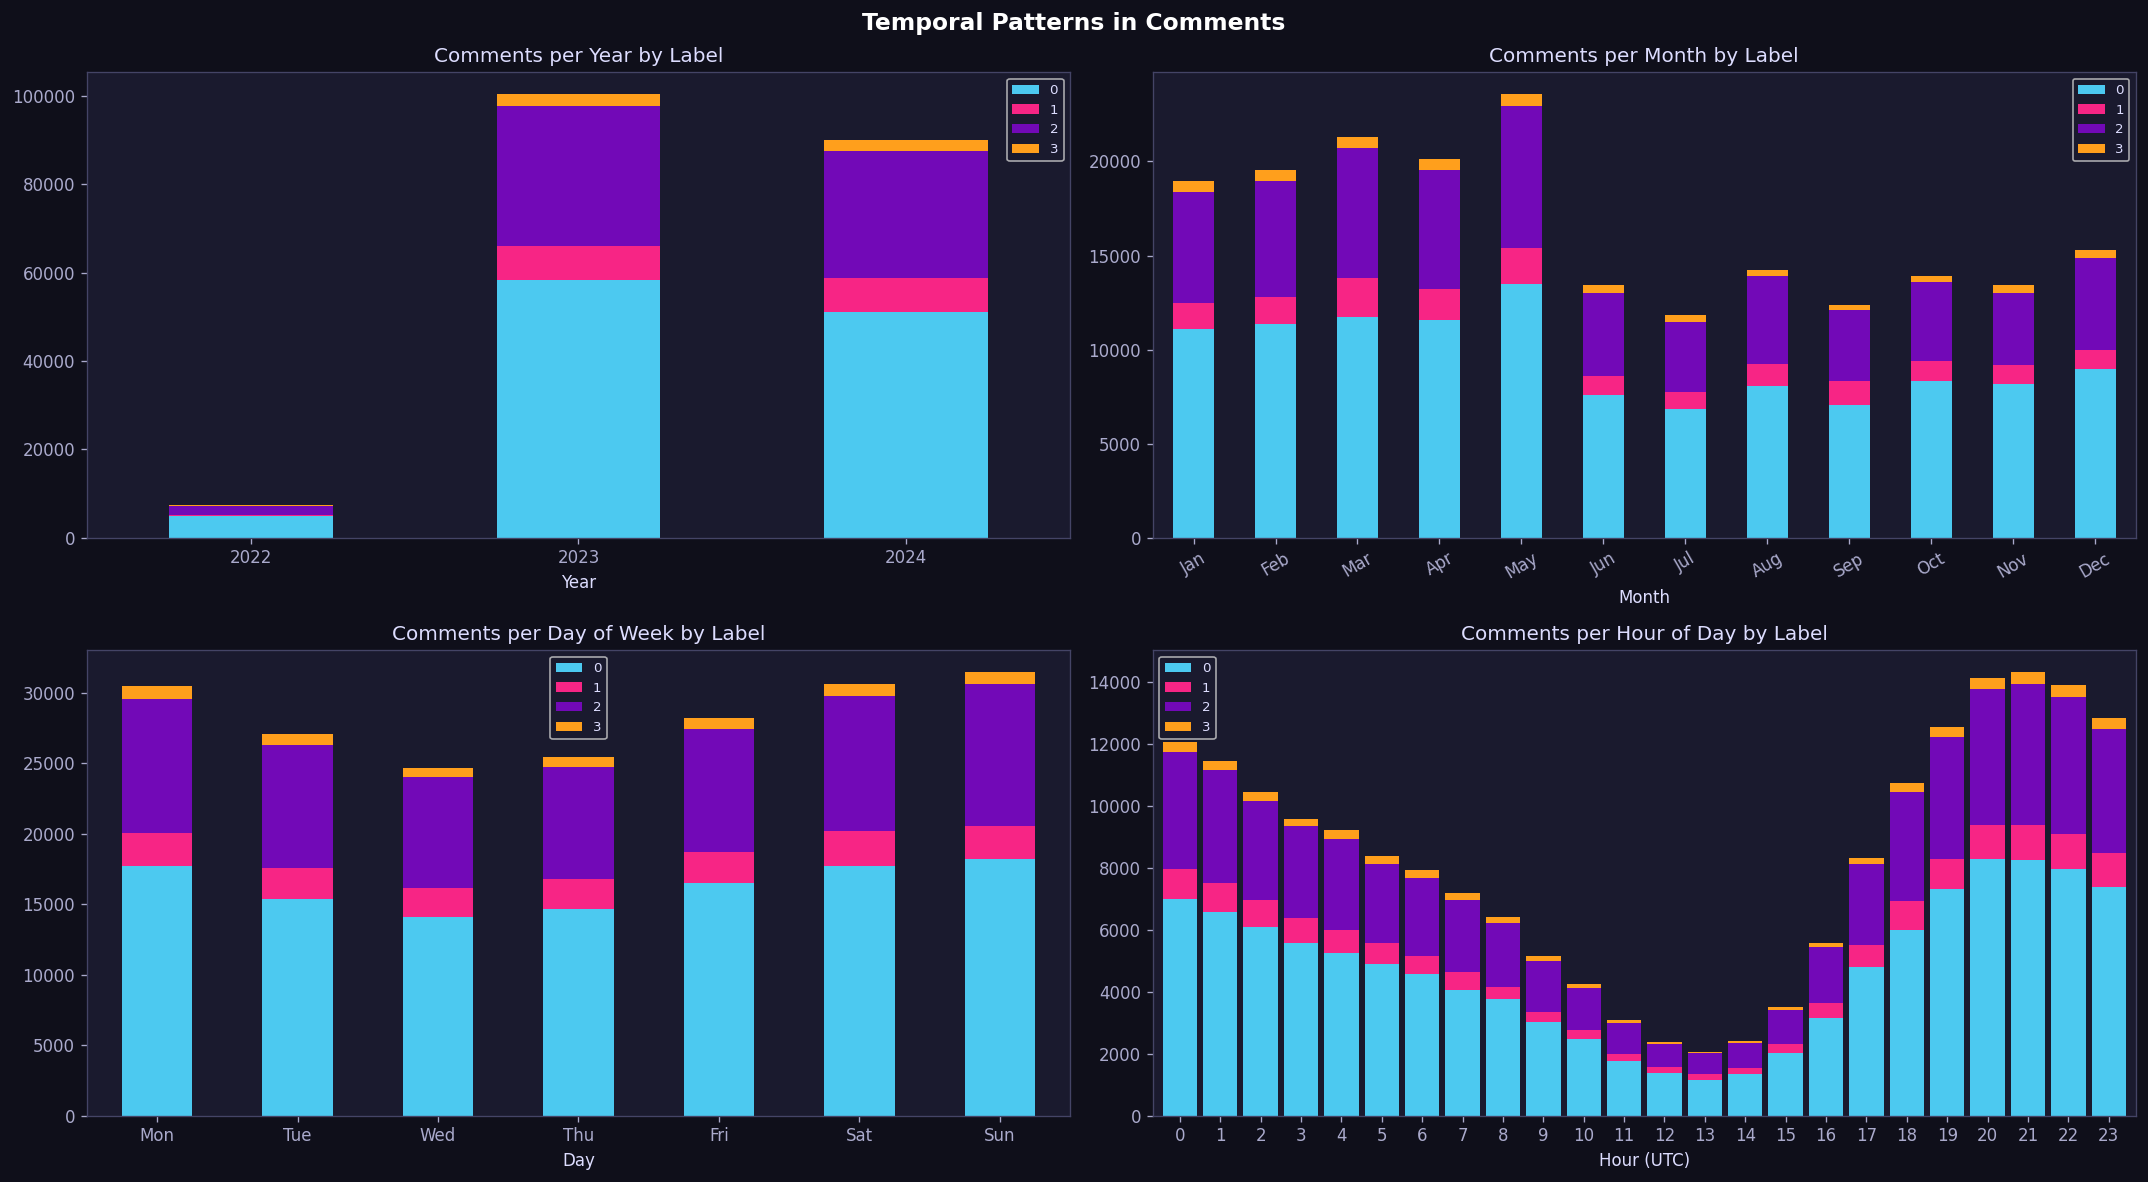

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Temporal Patterns in Comments', fontsize=14, color='white', fontweight='bold')
days   = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# By year
ax = axes[0, 0]
yearly = train.groupby(['year', 'label']).size().unstack(fill_value=0)
yearly.plot(kind='bar', stacked=True, ax=ax, color=PALETTE, edgecolor='none')
ax.set_title('Comments per Year by Label'); ax.set_xlabel('Year')
ax.legend([0,1,2,3], fontsize=8)
ax.tick_params(axis='x', rotation=0)

# By month
ax = axes[0, 1]
monthly = train.groupby(['month', 'label']).size().unstack(fill_value=0)
monthly.plot(kind='bar', stacked=True, ax=ax, color=PALETTE, edgecolor='none')
ax.set_title('Comments per Month by Label'); ax.set_xlabel('Month')
ax.set_xticklabels(months, rotation=30)
ax.legend([0,1,2,3], fontsize=8)

# By day of week
ax = axes[1, 0]
dow = train.groupby(['dayofweek', 'label']).size().unstack(fill_value=0)
dow.plot(kind='bar', stacked=True, ax=ax, color=PALETTE, edgecolor='none')
ax.set_title('Comments per Day of Week by Label'); ax.set_xlabel('Day')
ax.set_xticklabels(days, rotation=0)
ax.legend([0,1,2,3], fontsize=8)

# By hour
ax = axes[1, 1]
hourly = train.groupby(['hour', 'label']).size().unstack(fill_value=0)
hourly.plot(kind='bar', stacked=True, ax=ax, color=PALETTE, edgecolor='none', width=0.85)
ax.set_title('Comments per Hour of Day by Label'); ax.set_xlabel('Hour (UTC)')
ax.legend([0,1,2,3], fontsize=8)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout(); plt.show()

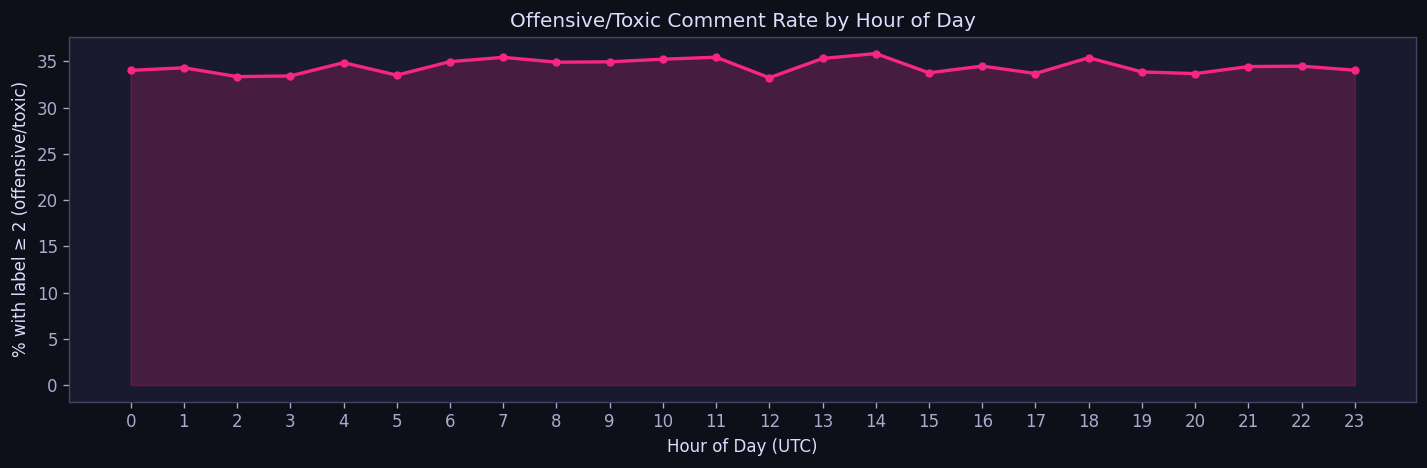

Highest: Hour 14 (35.8%)
Lowest:  Hour 12 (33.2%)


In [34]:
# Toxic comment % by hour — does time of day matter?
hourly_pct = train.groupby('hour')['label'].apply(lambda x: (x >= 2).mean() * 100)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(hourly_pct.index, hourly_pct.values, color='#f72585', linewidth=2, marker='o', markersize=4)
ax.fill_between(hourly_pct.index, hourly_pct.values, alpha=0.2, color='#f72585')
ax.set_xlabel('Hour of Day (UTC)'); ax.set_ylabel('% with label ≥ 2 (offensive/toxic)')
ax.set_title('Offensive/Toxic Comment Rate by Hour of Day')
ax.set_xticks(range(0, 24))
plt.tight_layout(); plt.show()

print(f'Highest: Hour {hourly_pct.idxmax()} ({hourly_pct.max():.1f}%)')
print(f'Lowest:  Hour {hourly_pct.idxmin()} ({hourly_pct.min():.1f}%)')

## 8. Cross-Feature Analysis (Label vs All Features)

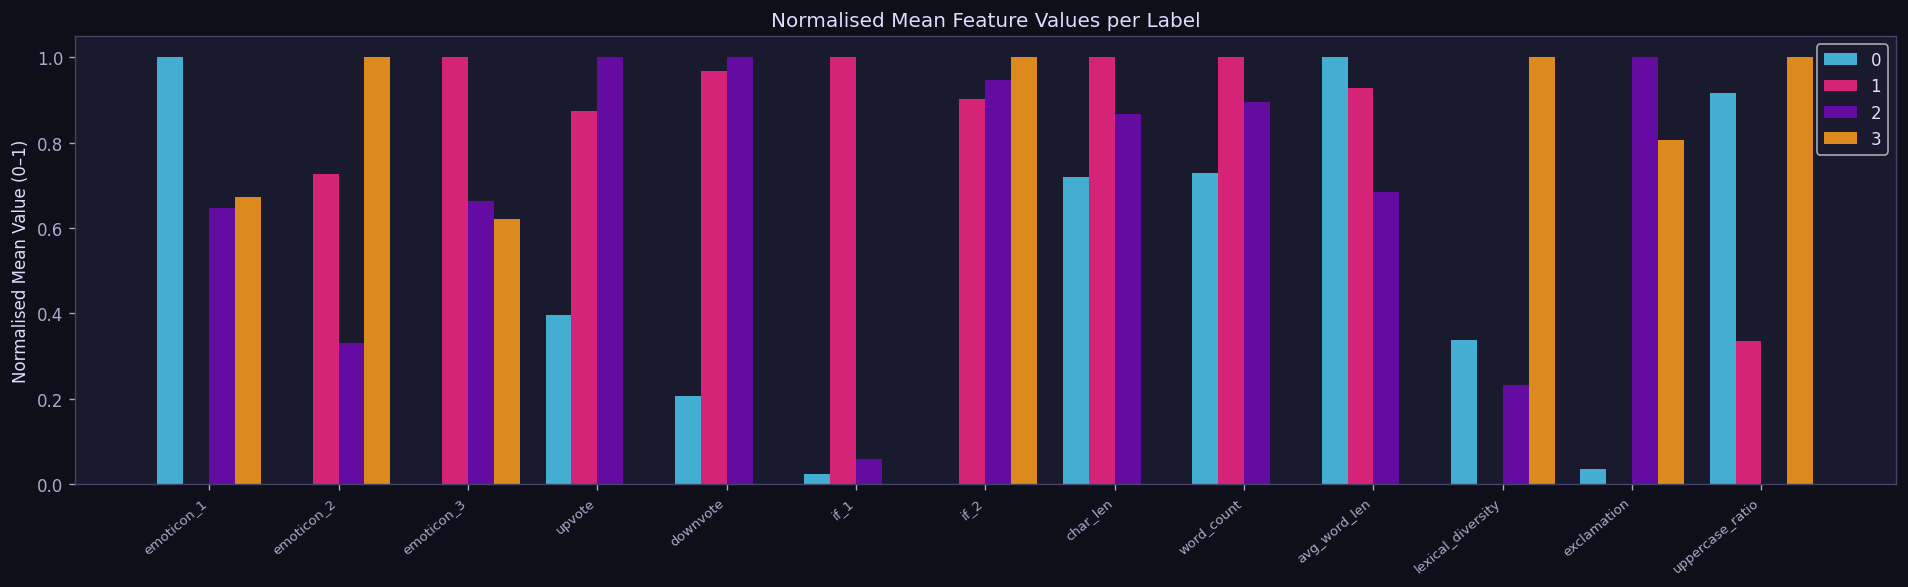

In [35]:
# Mean feature values per label (normalised for comparability)
features_to_compare = num_cols + ['char_len', 'word_count', 'avg_word_len',
                                   'lexical_diversity', 'exclamation', 'uppercase_ratio']
group_means = train.groupby('label')[features_to_compare].mean()

# Normalize each feature 0–1
normed = (group_means - group_means.min()) / (group_means.max() - group_means.min() + 1e-9)

fig, ax = plt.subplots(figsize=(16, 5))
x = np.arange(len(features_to_compare))
width = 0.2
for i, (lbl, color) in enumerate(zip(sorted(train['label'].unique()), PALETTE)):
    ax.bar(x + i * width, normed.loc[lbl], width=width, label=lbl,
           color=color, alpha=0.85, edgecolor='none')

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(features_to_compare, rotation=40, ha='right', fontsize=8)
ax.set_ylabel('Normalised Mean Value (0–1)')
ax.set_title('Normalised Mean Feature Values per Label')
ax.legend()
plt.tight_layout(); plt.show()

In [36]:
# Pair-wise Mann-Whitney U for top features between label 0 and label 3
print('==== Pairwise Mann-Whitney U: Label 0 vs Label 3 ====')
l0 = train[train['label'] == 0]
l3 = train[train['label'] == 3]

mw_results = []
for feat in features_to_compare:
    stat, p = mannwhitneyu(l0[feat].dropna(), l3[feat].dropna(), alternative='two-sided')
    # Common language effect size
    n0, n3   = len(l0[feat].dropna()), len(l3[feat].dropna())
    cles     = stat / (n0 * n3)
    mw_results.append({'feature': feat, 'U': stat, 'p-value': p,
                        'sig': '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns')),
                        'CLES (effect)': cles})

mw_train = pd.DataFrame(mw_results).set_index('feature').sort_values('p-value')
display(mw_train.round(4))

==== Pairwise Mann-Whitney U: Label 0 vs Label 3 ====


,U,p-value,sig,CLES (effect)
feature,,,,
if_2,21749221.5,0.0000,***,0.0348
char_len,383357539.0,0.0000,***,0.6139
avg_word_len,378706810.5,0.0000,***,0.6065
word_count,376290176.0,0.0000,***,0.6026
lexical_diversity,256899297.0,0.0000,***,0.4114
emoticon_2,305483183.5,0.0000,***,0.4892
upvote,331203900.5,0.0000,***,0.5304
exclamation,303979615.0,0.0000,***,0.4868
emoticon_3,305808181.5,0.0000,***,0.4898


## 9. Outlier Detection

In [37]:
print('==== Outlier Analysis (IQR method) ====')
outlier_summary = []
for col in features_to_compare:
    Q1  = train[col].quantile(0.25)
    Q3  = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out = ((train[col] < lower) | (train[col] > upper)).sum()
    pct   = n_out / len(train) * 100
    outlier_summary.append({'feature': col, 'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                             'Lower fence': lower, 'Upper fence': upper,
                             'Outliers': n_out, 'Outlier %': pct})

out_df = pd.DataFrame(outlier_summary).set_index('feature')
display(out_df.round(3))

==== Outlier Analysis (IQR method) ====


,Q1,Q3,IQR,Lower fence,Upper fence,Outliers,Outlier %
feature,,,,,,,
emoticon_1,0.000,0.000,0.000,0.000,0.000,28922,14.607
emoticon_2,0.000,0.000,0.000,0.000,0.000,8109,4.095
emoticon_3,0.000,0.000,0.000,0.000,0.000,17165,8.669
upvote,0.000,3.000,3.000,-4.500,7.500,17304,8.739
downvote,0.000,1.000,1.000,-1.500,2.500,15173,7.663
if_1,0.000,4.000,4.000,-6.000,10.000,85,0.043
if_2,4.000,10.000,6.000,-5.000,19.000,3930,1.985
char_len,102.000,419.000,317.000,-373.500,894.500,12822,6.476
word_count,18.000,73.000,55.000,-64.500,155.500,11131,5.622


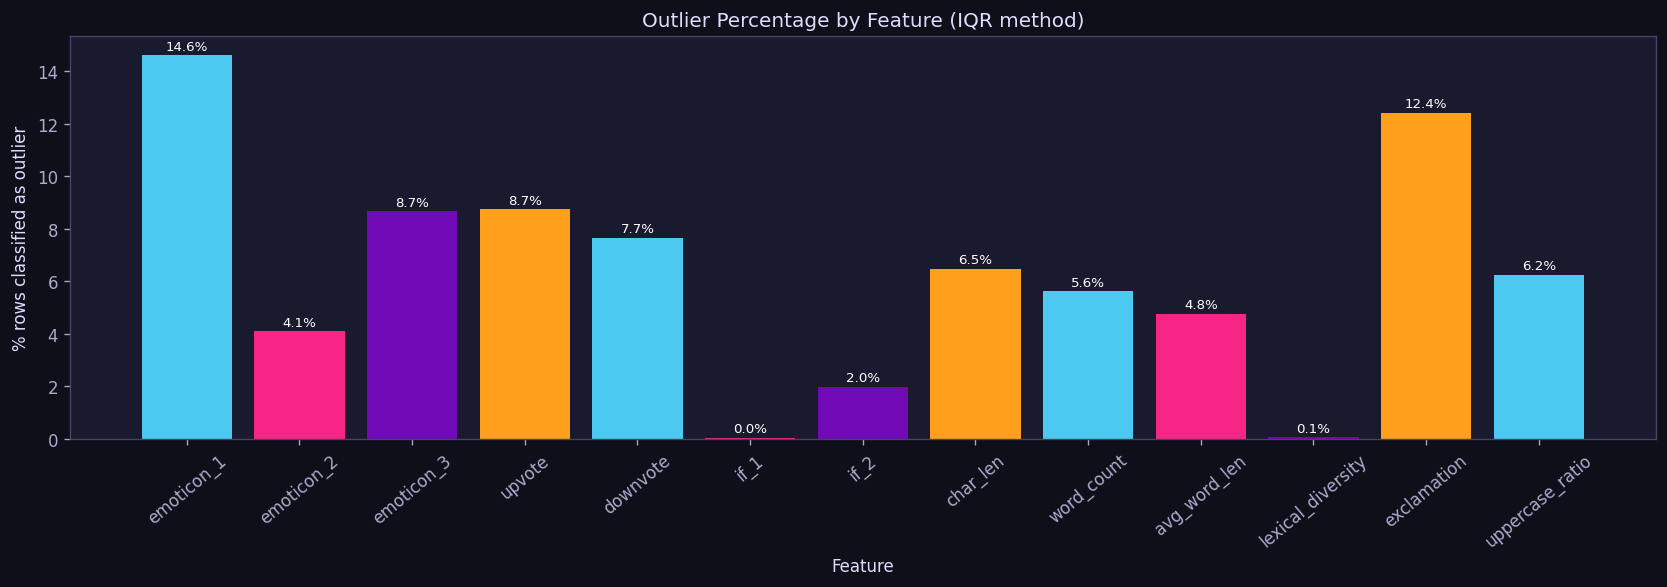

In [38]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(out_df.index, out_df['Outlier %'],
       color=[PALETTE[i % 4] for i in range(len(out_df))], edgecolor='none')
for i, v in enumerate(out_df['Outlier %']):
    ax.text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom', fontsize=8, color='white')
ax.set_xlabel('Feature'); ax.set_ylabel('% rows classified as outlier')
ax.set_title('Outlier Percentage by Feature (IQR method)')
ax.tick_params(axis='x', rotation=40)
plt.tight_layout(); plt.show()

# Data Preprocessing + NLP + Milestone 2

In [5]:
LABEL_NAMES = {0: 'Neutral (0)', 1: 'Mild (1)', 2: 'Offensive (2)', 3: 'Toxic (3)'}
df_train = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/train.csv', 
                       parse_dates=['created_date'])
df_test  = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/test.csv',  
                       parse_dates=['created_date'])

print(f'Train: {df_train.shape}  |  Test: {df_test.shape}')
df_train.head(3)

Train: (198000, 15)  |  Test: (102000, 14)


,created_date,post_id,emoticon_1,emoticon_2,emoticon_3,upvote,downvote,if_1,if_2,race,religion,gender,disability,comment,label
0,2024-01-18 08:43:57.397508+00:00,73,0,0,0,0,1,0,10,NaN,NaN,NaN,False,She might be a bright spot for a party keou on...,2
1,2024-03-24 21:43:11.490017+00:00,39,0,0,0,6,0,0,4,NaN,NaN,NaN,False,"Under Alaska law, a non-tribal member is not b...",0
2,2024-04-24 20:32:17.014931+00:00,31,0,1,1,0,0,0,10,NaN,NaN,NaN,False,in the future please spare me your strawman dr...,2


## 1. Basic Cleaning

In [6]:
n_before = len(df_train)
df_train = df_train.dropna(subset=['comment']).copy()
print(f'Dropped {n_before - len(df_train)} null-comment row(s). Remaining: {len(df_train):,}')

dup_counts = df_train['comment'].value_counts()
n_dup_texts = (dup_counts > 1).sum()
print(f'\nUnique comment texts appearing >1 time: {n_dup_texts}')
print('Top 10 most repeated texts:')
display(dup_counts.head(10).to_frame('count'))

print('\n→ Keeping all duplicates; same text may carry different labels.')

Dropped 1 null-comment row(s). Remaining: 197,999

Unique comment texts appearing >1 time: 103
Top 10 most repeated texts:


,count
comment,
Exactly..,8
Troll,8
Exactly,6
Yes,6
No,6
Liar,5
Well said,5
What?,4
Good,4



→ Keeping all duplicates; same text may carry different labels.


## 2. Text Processing

In [7]:
STOPWORDS = frozenset([
    'a','about','above','after','again','against','all','am','an','and','any',
    'are','as','at','be','because','been','before','being','below','between',
    'both','but','by','can','did','do','does','doing','down','during','each',
    'few','for','from','further','get','got','had','has','have','having','he',
    'her','here','hers','herself','him','himself','his','how','i','if','in',
    'into','is','it','its','itself','just','me','more','most','my','myself',
    'no','nor','not','now','of','off','on','once','only','or','other','our',
    'ours','ourselves','out','own','same','she','should','so','some','such',
    'than','that','the','their','theirs','them','themselves','then','there',
    'these','they','this','those','through','to','too','under','until','up',
    'us','very','was','we','were','what','when','where','which','while','who',
    'whom','why','will','with','you','your','yours','yourself','yourselves',
    'also','may','might','shall','would','could','cannot','let','ve','ll','re',
    'd','s','m','t',
])


CONTRACTIONS = {
    "won't":"will not",  "can't":"cannot",      "i'm":"i am",
    "i've":"i have",     "i'll":"i will",        "i'd":"i would",
    "you're":"you are",  "you've":"you have",    "you'll":"you will",
    "you'd":"you would", "he's":"he is",         "he'd":"he would",
    "she's":"she is",    "she'd":"she would",    "it's":"it is",
    "we're":"we are",    "we've":"we have",      "we'll":"we will",
    "we'd":"we would",   "they're":"they are",   "they've":"they have",
    "they'll":"they will","they'd":"they would","that's":"that is",
    "isn't":"is not",    "aren't":"are not",     "wasn't":"was not",
    "weren't":"were not","haven't":"have not",   "hasn't":"has not",
    "hadn't":"had not",  "wouldn't":"would not", "couldn't":"could not",
    "shouldn't":"should not", "doesn't":"does not", "don't":"do not",
    "didn't":"did not",  "let's":"let us",        "what's":"what is",
    "who's":"who is",    "where's":"where is",   "there's":"there is",
    "n't":" not",
}

_CONTRACTION_RE = re.compile(
    r'\b(' + '|'.join(re.escape(k) for k in sorted(CONTRACTIONS, key=len, reverse=True)) + r')\b',
    re.IGNORECASE
)

def expand_contractions(text):
    return _CONTRACTION_RE.sub(lambda m: CONTRACTIONS.get(m.group(0).lower(), m.group(0)), text)

print('Stopword list size:', len(STOPWORDS))
print('Contraction mappings:', len(CONTRACTIONS))

Stopword list size: 141
Contraction mappings: 43


In [8]:
_SUFFIX_RULES = [
    ('ational', 'ate'), ('tional', 'tion'), ('enci', 'ence'), ('anci', 'ance'),
    ('izer', 'ize'),    ('ising', 'ise'),   ('izing', 'ize'), ('ising', 'ise'),
    ('ational', 'ate'), ('alism', 'al'),    ('iveness', 'ive'), ('fulness', 'ful'),
    ('ousness', 'ous'), ('aliti', 'al'),    ('iviti', 'ive'), ('biliti', 'ble'),
    ('icate', 'ic'),    ('ical', 'ic'),     ('alize', 'al'), ('iciti', 'ic'),
    ('ness', ''),       ('ment', ''),       ('ation', 'ate'), ('ations', 'ate'),
    ('ating', 'ate'),   ('ated', 'ate'),    ('ates', 'ate'),  ('ator', 'ate'),
    ('alism', 'al'),    ('alise', 'al'),    ('alize', 'al'),
    ('sses', 'ss'),     ('ies', 'i'),       ('ing', ''),      ('ed', ''),
    ('ies', 'y'),       ('ier', 'y'),       ('iest', 'y'),    ('ness', ''),
    ('er', ''),         ('ly', ''),         ('ers', ''),      ('s', ''),
]

def stem_word(word):
    if len(word) <= 3:
        return word
    for suffix, replacement in _SUFFIX_RULES:
        if word.endswith(suffix) and len(word) - len(suffix) >= 3:
            return word[:-len(suffix)] + replacement
    return word

tests = ['running', 'happiness', 'nationalization', 'quickly', 'dogs']
for t in tests:
    print(f'  {t:20s} → {stem_word(t)}')

  running              → runn
  happiness            → happi
  nationalization      → nationalizate
  quickly              → quick
  dogs                 → dog


In [9]:
# Full NLP cleaning pipeline 

_PUNCT_TABLE = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
_MULTI_SPACE = re.compile(r'\s+')
_URL_RE      = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
_HTML_RE     = re.compile(r'<[^>]+>')
_NON_ASCII   = re.compile(r'[^\x00-\x7F]+')
_ALPHA_TOK   = re.compile(r'[a-z]+')

def clean_text(text, remove_stopwords=True, do_stem=True):
    """
    NLP pipeline (NO external NLP library):
      1. Guard against non-string
      2. Lowercase
      3. Remove URLs
      4. Remove HTML tags
      5. Expand contractions
      6. Replace punctuation with spaces
      7. Remove non-ASCII characters
      8. Tokenise (extract alpha-only tokens with regex)
      9. Remove stopwords
     10. Suffix-strip stemming
     11. Rejoin
    """
    if not isinstance(text, str) or not text.strip():
        return ''
    text = text.lower()
    text = _URL_RE.sub(' ', text)
    text = _HTML_RE.sub(' ', text)
    text = expand_contractions(text)
    text = text.translate(_PUNCT_TABLE)
    text = _NON_ASCII.sub(' ', text)
    tokens = _ALPHA_TOK.findall(text)          # pure alpha tokens only
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    if do_stem:
        tokens = [stem_word(t) for t in tokens]
    return ' '.join(tokens)


def light_clean(text):
    """
    Minimal clean (preserve casing, punctuation, stopwords).
    For bag-of-words models that may benefit from punctuation signals.
    """
    if not isinstance(text, str):
        return ''
    text = _URL_RE.sub(' ', text)
    text = _HTML_RE.sub(' ', text)
    text = _NON_ASCII.sub(' ', text)
    return _MULTI_SPACE.sub(' ', text).strip()


print('Cleaning train text...')
df_train['comment_clean'] = df_train['comment'].apply(clean_text)
df_train['comment_light'] = df_train['comment'].apply(light_clean)

print('Cleaning test text...')
df_test['comment_clean'] = df_test['comment'].apply(clean_text)
df_test['comment_light'] = df_test['comment'].apply(light_clean)

i = 10
print(f'\nOriginal : {df_train["comment"].iloc[i][:200]}')
print(f'Cleaned  : {df_train["comment_clean"].iloc[i][:200]}')
print(f'Light    : {df_train["comment_light"].iloc[i][:200]}')

Cleaning train text...
Cleaning test text...

Original : You're right the words Muslim ban came straight from trump.
Cleaned  : right word muslim ban came straight trump
Light    : You're right the words Muslim ban came straight from trump.


In [10]:
# Pipeline coverage check 
n_empty_after = (df_train['comment_clean'] == '').sum()
print(f'Empty strings after cleaning: {n_empty_after}')

# Avg token count before/after stop-word removal
raw_tokens  = df_train['comment'].fillna('').str.split().str.len()
clean_tokens= df_train['comment_clean'].str.split().str.len()
print(f'Avg word count — raw: {raw_tokens.mean():.1f}  |  cleaned: {clean_tokens.mean():.1f}')
print(f'Vocab compression  : {clean_tokens.mean()/raw_tokens.mean()*100:.0f} % of original')

Empty strings after cleaning: 264
Avg word count — raw: 52.4  |  cleaned: 26.5
Vocab compression  : 51 % of original


## 3. Text Feature Engineering

In [11]:
# Features derived from the RAW / LIGHT-CLEANED text (before stopword removal)
# so stylistic signals (punctuation, casing) are still present.

def extract_text_features(df, col='comment'):
    """
    Returns a DataFrame of per-row text statistics.
    EDA showed these are statistically significant across labels.
    """
    text  = df[col].fillna('')
    words = text.str.split()

    f = pd.DataFrame(index=df.index)

    # --- Length / structure ---
    f['char_len']           = text.str.len()
    f['word_count']         = words.str.len().fillna(0).astype(int)
    f['sentence_count']     = text.str.count(r'[.!?]+') + 1
    f['avg_word_len']       = words.apply(
        lambda ws: np.mean([len(w) for w in ws]) if ws and len(ws) > 0 else 0)
    f['avg_sentence_len']   = f['word_count'] / f['sentence_count'].clip(lower=1)

    # --- Lexical diversity ---
    f['unique_word_ratio']  = text.apply(
        lambda t: len(set(t.lower().split())) / max(len(t.split()), 1))

    # --- Stylistic / affect signals ---
    f['uppercase_ratio']    = text.apply(
        lambda t: sum(1 for c in t if c.isupper()) / max(len(t), 1))
    f['exclamation_cnt']    = text.str.count('!')
    f['question_cnt']       = text.str.count(r'\?')
    f['special_char_cnt']   = text.apply(
        lambda t: sum(1 for c in t if not c.isalnum() and c != ' '))
    f['digit_ratio']        = text.apply(
        lambda t: sum(c.isdigit() for c in t) / max(len(t), 1))

    # --- Punctuation density ---
    f['punct_density']      = text.apply(
        lambda t: sum(c in string.punctuation for c in t) / max(len(t), 1))

    # --- Capitalised words count (ALL-CAPS words, a toxicity marker) ---
    f['all_caps_word_cnt']  = words.apply(
        lambda ws: sum(1 for w in ws if w.isupper() and len(w) > 1) if ws else 0)

    return f


text_feats_train = extract_text_features(df_train)
text_feats_test  = extract_text_features(df_test)

print('Text feature shapes:', text_feats_train.shape, text_feats_test.shape)
display(text_feats_train.describe().round(3))

Text feature shapes: (197999, 13) (102000, 13)


,char_len,word_count,sentence_count,avg_word_len,avg_sentence_len,unique_word_ratio,uppercase_ratio,exclamation_cnt,question_cnt,special_char_cnt,digit_ratio,punct_density,all_caps_word_cnt
count,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000
mean,302.911,52.397,4.751,4.908,10.578,0.869,0.036,0.224,0.440,10.775,0.004,0.038,0.687
std,266.442,45.770,3.233,2.804,6.460,0.106,0.043,0.952,0.992,11.237,0.013,0.033,2.190
min,1.000,1.000,1.000,1.000,0.167,0.055,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,102.000,18.000,2.000,4.389,6.333,0.789,0.018,0.000,0.000,3.000,0.000,0.022,0.000
50%,211.000,37.000,4.000,4.714,9.667,0.878,0.027,0.000,0.000,7.000,0.000,0.031,0.000
75%,419.000,73.000,6.000,5.083,13.571,0.962,0.041,0.000,1.000,14.000,0.000,0.045,1.000
max,1892.000,315.000,57.000,333.000,188.000,1.000,1.000,96.000,49.000,506.000,1.000,1.000,158.000


In [12]:
# ── Kruskal-Wallis significance test for each text feature vs label ────────────
from scipy.stats import kruskal

groups = [df_train[df_train['label'] == lbl] for lbl in sorted(df_train['label'].unique())]
rows = []
for feat in text_feats_train.columns:
    g = [text_feats_train.loc[grp.index, feat].dropna().values for grp in groups]
    stat, p = kruskal(*g)
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
    rows.append({'feature': feat, 'H': round(stat, 2), 'p-value': f'{p:.2e}', 'sig': sig})

kw_df = pd.DataFrame(rows).set_index('feature').sort_values('H', ascending=False)
display(kw_df)

,H,p-value,sig
feature,,,
char_len,2347.48,0.00e+00,***
word_count,2048.44,0.00e+00,***
avg_word_len,1691.75,0.00e+00,***
special_char_cnt,1622.47,0.00e+00,***
sentence_count,1554.94,0.00e+00,***
digit_ratio,1161.24,1.88e-251,***
unique_word_ratio,1158.22,8.49e-251,***
avg_sentence_len,1038.97,6.32e-225,***
exclamation_cnt,348.90,2.59e-75,***


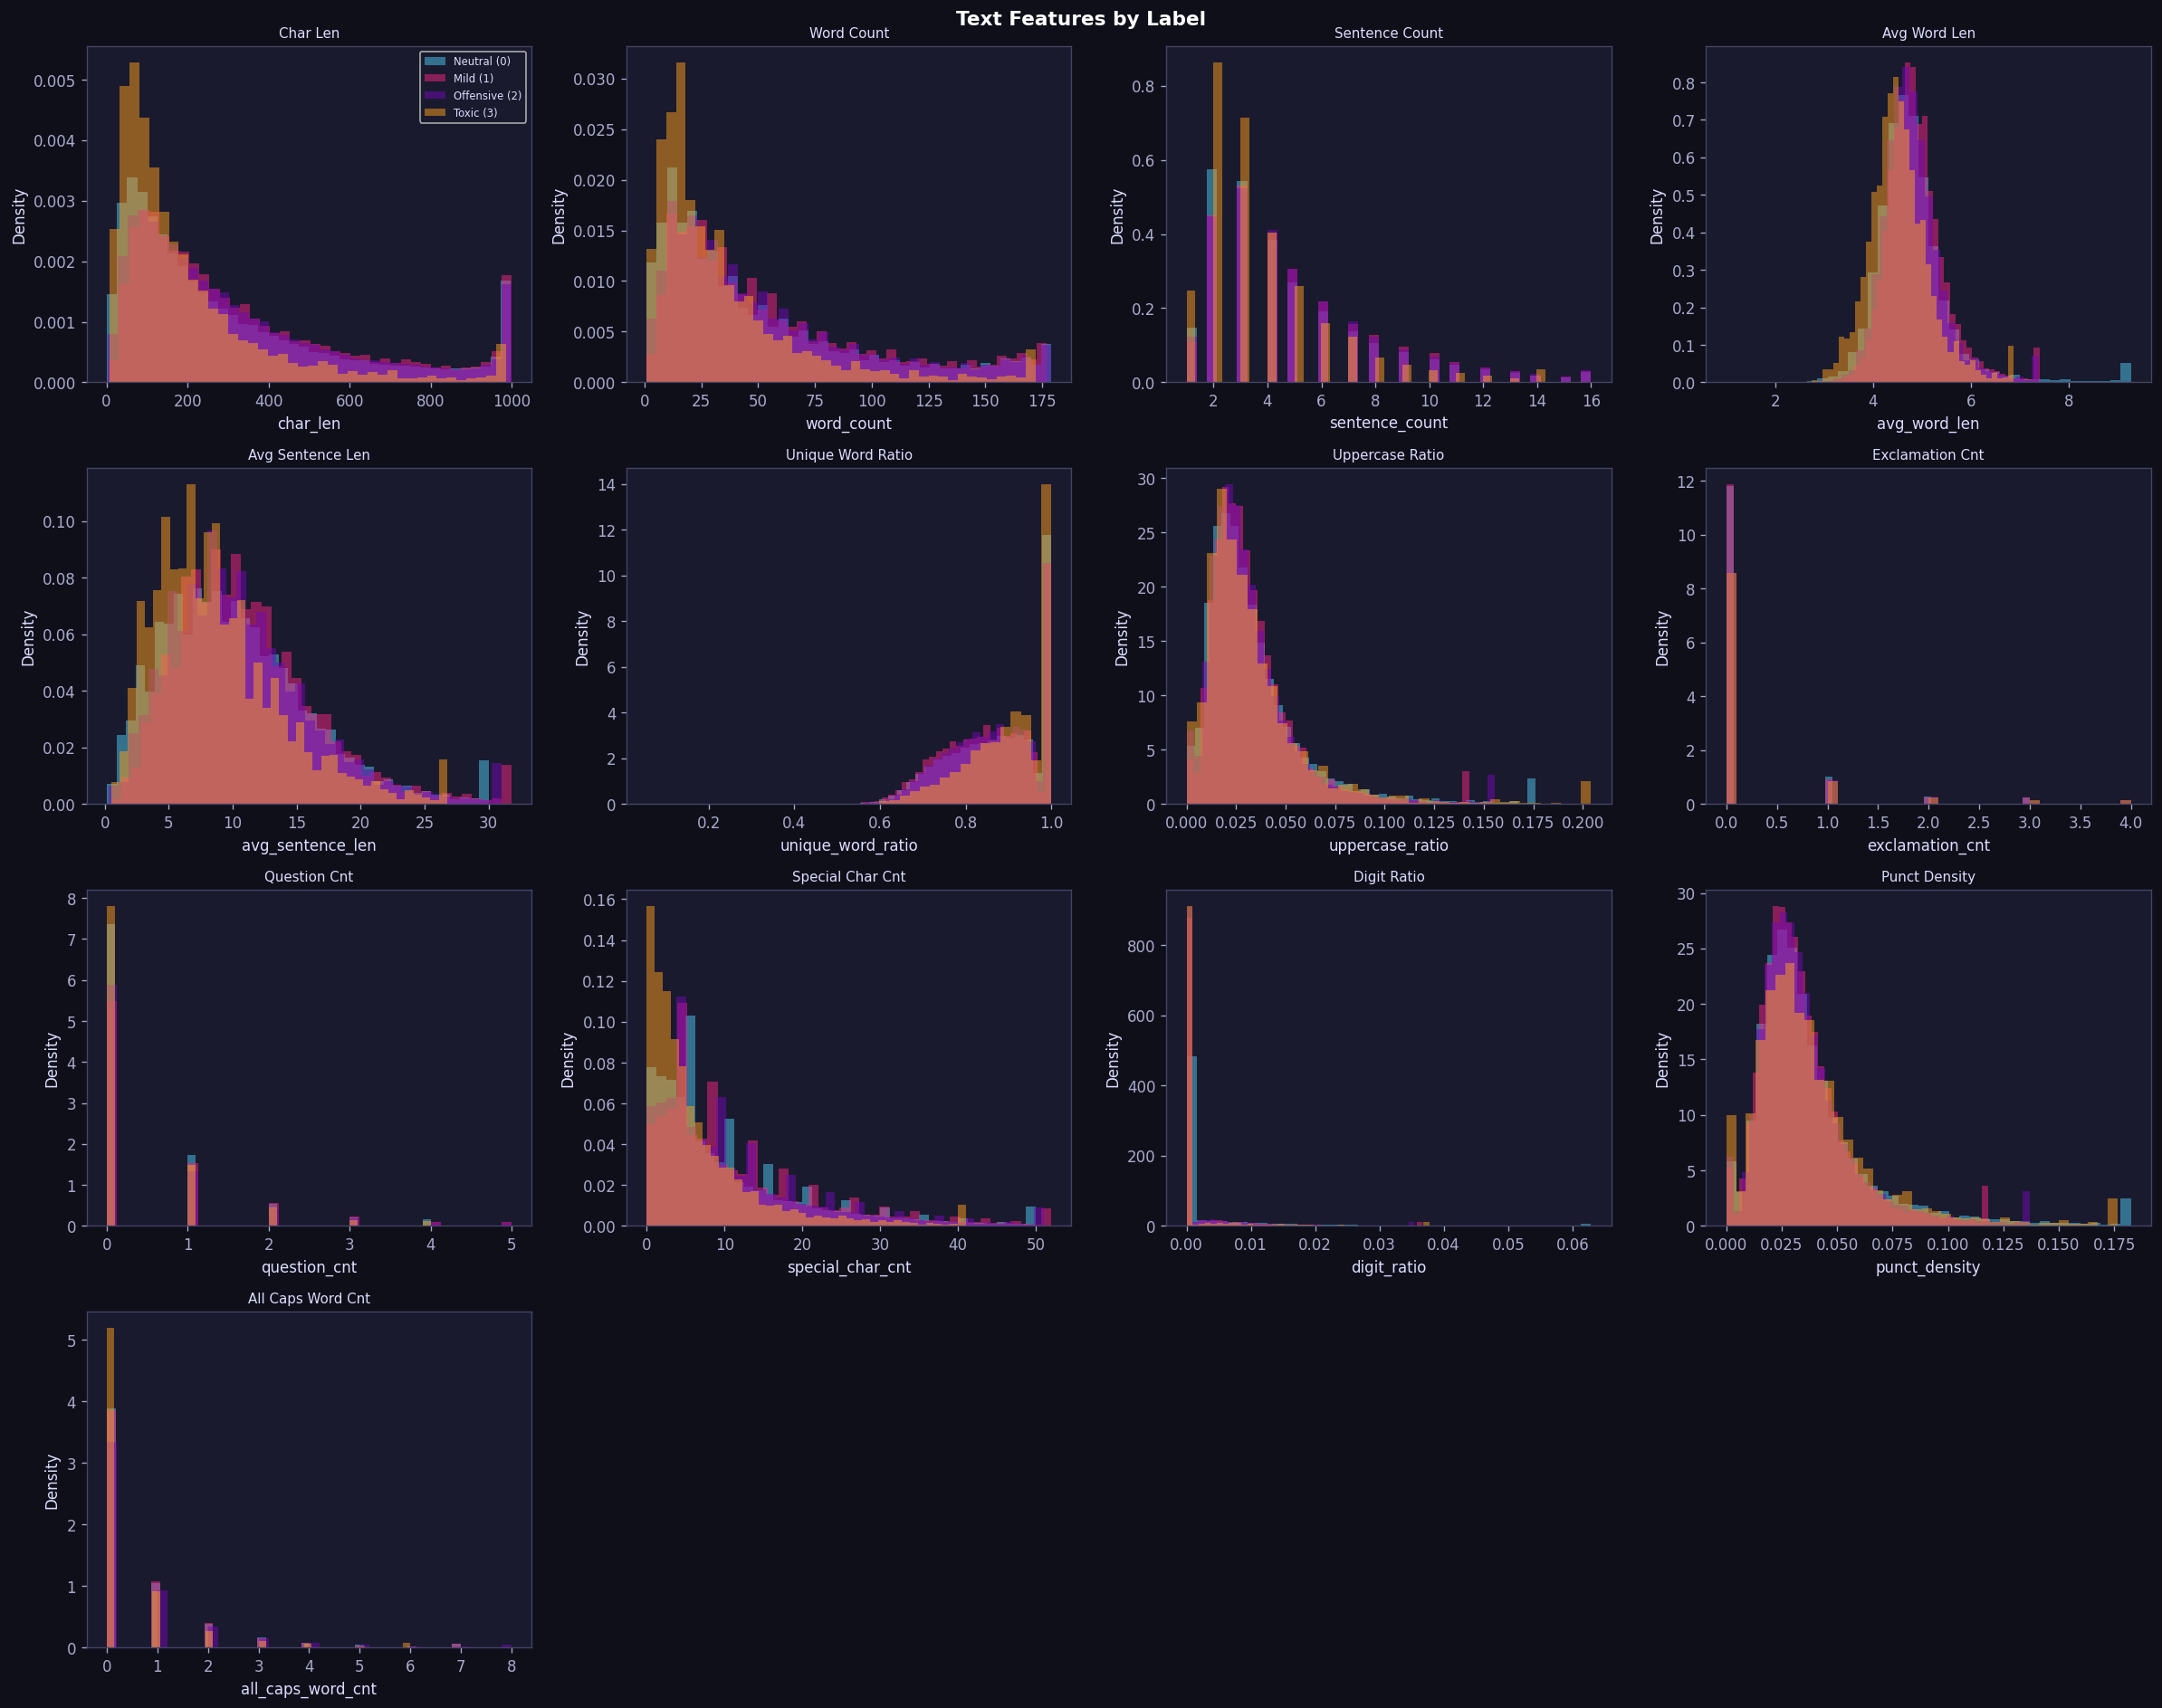

In [13]:
# ── Distribution by label ─────────────────────────────────────────────────────
feat_viz = text_feats_train.copy()
feat_viz['label'] = df_train['label'].values

cols_to_plot = text_feats_train.columns.tolist()
n = len(cols_to_plot)
ncols, nrows = 4, (n + 3) // 4

fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
axes = axes.flatten()
fig.suptitle('Text Features by Label', fontsize=13, color='white', fontweight='bold')

for i, feat in enumerate(cols_to_plot):
    ax = axes[i]
    for lbl, color in zip(sorted(df_train['label'].unique()), PALETTE):
        data = feat_viz[feat_viz['label'] == lbl][feat]
        data = data.clip(upper=data.quantile(0.99))
        ax.hist(data, bins=40, alpha=0.5, color=color, label=LABEL_NAMES[lbl], density=True)
    ax.set_title(feat.replace('_', ' ').title(), fontsize=9)
    ax.set_xlabel(feat); ax.set_ylabel('Density')
    if i == 0: ax.legend(fontsize=7)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(); plt.show()

## 4. Metadata Feature Engineering

In [14]:
def build_metadata_features(df):
    feats = pd.DataFrame(index=df.index)

    # Raw numeric features 
    feats['emoticon_1']    = df['emoticon_1']
    feats['emoticon_2']    = df['emoticon_2']
    feats['emoticon_3']    = df['emoticon_3']
    feats['emoticon_sum']  = df['emoticon_1'] + df['emoticon_2'] + df['emoticon_3']
    feats['upvote']        = df['upvote']
    feats['downvote']      = df['downvote']

    # Vote-ratio (avoids div-by-zero with +1 smoothing)
    total_votes = df['upvote'] + df['downvote']
    feats['upvote_ratio']  = df['upvote'] / (total_votes + 1)
    feats['vote_sum']      = total_votes

    # if_1, if_2 — clip extreme outliers at 99th percentile (EDA: max ~1860)
    if_1_cap = df['if_1'].quantile(0.99)
    if_2_cap = df['if_2'].quantile(0.99)
    feats['if_1_clipped']  = df['if_1'].clip(upper=if_1_cap)
    feats['if_2_clipped']  = df['if_2'].clip(upper=if_2_cap)
    feats['if_ratio']      = feats['if_1_clipped'] / (feats['if_2_clipped'] + 1)

    # Log-transforms for skewed features 
    for col in ['upvote', 'downvote', 'vote_sum', 'if_1_clipped', 'if_2_clipped']:
        feats[f'log_{col}'] = np.log1p(feats[col])

    # Demographic signals 
    # 73 % of race/religion/gender are co-missing → one binary flag captures it
    feats['has_demographic'] = (~df['race'].isnull()).astype(int)
    feats['disability']      = df['disability'].astype(int)

    # Temporal features 
    hour      = df['created_date'].dt.hour
    dayofweek = df['created_date'].dt.dayofweek
    month     = df['created_date'].dt.month

    # Cyclical encoding — preserves 23h→0h continuity etc.
    feats['hour_sin']       = np.sin(2 * np.pi * hour      / 24)
    feats['hour_cos']       = np.cos(2 * np.pi * hour      / 24)
    feats['dayofweek_sin']  = np.sin(2 * np.pi * dayofweek / 7)
    feats['dayofweek_cos']  = np.cos(2 * np.pi * dayofweek / 7)
    feats['month_sin']      = np.sin(2 * np.pi * month     / 12)
    feats['month_cos']      = np.cos(2 * np.pi * month     / 12)

    return feats


meta_feats_train = build_metadata_features(df_train)
meta_feats_test  = build_metadata_features(df_test)

print('Metadata feature shapes:', meta_feats_train.shape, meta_feats_test.shape)
display(meta_feats_train.describe().round(3))

Metadata feature shapes: (197999, 24) (102000, 24)


,emoticon_1,emoticon_2,emoticon_3,emoticon_sum,upvote,downvote,upvote_ratio,vote_sum,if_1_clipped,if_2_clipped,...,log_if_1_clipped,log_if_2_clipped,has_demographic,disability,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
count,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,...,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000,197999.000
mean,0.280,0.048,0.121,0.449,2.608,0.666,0.375,3.274,1.508,7.794,...,0.489,2.014,0.266,0.014,-0.073,0.310,-0.053,0.032,0.139,-0.006
std,1.023,0.258,0.481,1.254,5.055,2.044,0.339,6.019,2.806,8.247,...,0.830,0.477,0.442,0.117,0.725,0.610,0.703,0.708,0.702,0.698
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,...,0.000,1.386,0.000,0.000,-1.000,-1.000,-0.975,-0.901,-1.000,-1.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,...,0.000,1.609,0.000,0.000,-0.866,-0.259,-0.782,-0.901,-0.500,-0.500
50%,0.000,0.000,0.000,0.000,1.000,0.000,0.500,1.000,0.000,6.000,...,0.000,1.946,0.000,0.000,-0.259,0.500,0.000,-0.223,0.500,0.000
75%,0.000,0.000,0.000,0.000,3.000,1.000,0.667,4.000,4.000,10.000,...,1.609,2.398,1.000,0.000,0.707,0.866,0.782,0.623,0.866,0.500
max,47.000,11.000,17.000,60.000,201.000,107.000,0.994,241.000,10.000,66.000,...,2.398,4.205,1.000,1.000,1.000,1.000,0.975,1.000,1.000,1.000


## 5. Categorical Encoding

In [15]:
CAT_COLS = ['race', 'religion', 'gender']

def encode_categoricals(df, ref_columns=None):
    filled   = df[CAT_COLS].fillna('none')
    encoded  = pd.get_dummies(filled, prefix=CAT_COLS)
    # Align to reference column set (from train) if supplied
    if ref_columns is not None:
        encoded = encoded.reindex(columns=ref_columns, fill_value=0)
    return encoded

cat_feats_train = encode_categoricals(df_train)
cat_feats_test  = encode_categoricals(df_test, ref_columns=cat_feats_train.columns)

print('Categorical feature shapes:', cat_feats_train.shape, cat_feats_test.shape)
print('Columns:', cat_feats_train.columns.tolist())

# Save column reference for future use
CAT_COLUMNS = cat_feats_train.columns.tolist()

Categorical feature shapes: (197999, 19) (102000, 19)
Columns: ['race_asian', 'race_black', 'race_latino', 'race_none', 'race_other', 'race_white', 'religion_atheist', 'religion_buddhist', 'religion_christian', 'religion_hindu', 'religion_jewish', 'religion_muslim', 'religion_none', 'religion_other', 'gender_female', 'gender_male', 'gender_none', 'gender_other', 'gender_transgender']


## 6. Feature Scaling

In [16]:
# Combine all dense features
dense_train = pd.concat([text_feats_train, meta_feats_train, cat_feats_train], axis=1)
dense_test  = pd.concat([text_feats_test,  meta_feats_test,  cat_feats_test],  axis=1)

print('Dense feature matrix shapes:', dense_train.shape, dense_test.shape)

# StandardScaler fit on TRAIN ONLY — prevent data leakage
scaler = StandardScaler()
dense_train_scaled = scaler.fit_transform(dense_train)
dense_test_scaled  = scaler.transform(dense_test)

print('Scaling complete.')

DENSE_COL_NAMES = dense_train.columns.tolist()
print(f'Total dense features: {len(DENSE_COL_NAMES)}')

Dense feature matrix shapes: (197999, 56) (102000, 56)
Scaling complete.
Total dense features: 56


## 7. Class Imbalance - Analysis & Strategy

In [17]:
y_train = df_train['label'].values

lbl_counts = pd.Series(y_train).value_counts().sort_index()
print('Label distribution:')
for lbl, cnt in lbl_counts.items():
    print(f'  {LABEL_NAMES[lbl]:18s}: {cnt:7,}  ({cnt/len(y_train)*100:.2f}%)')
print(f'  Imbalance ratio (max/min): {lbl_counts.max()/lbl_counts.min():.1f}x')

# Balanced class weights for sklearn / XGBoost
classes      = np.unique(y_train)
cw_values    = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw_values))
print('\nBalanced class weights:')
for lbl, w in class_weight_dict.items():
    print(f'  Label {lbl}: {w:.4f}')

Label distribution:
  Neutral (0)       : 114,172  (57.66%)
  Mild (1)          :  15,918  (8.04%)
  Offensive (2)     :  62,440  (31.54%)
  Toxic (3)         :   5,469  (2.76%)
  Imbalance ratio (max/min): 20.9x

Balanced class weights:
  Label 0: 0.4336
  Label 1: 3.1097
  Label 2: 0.7928
  Label 3: 9.0510


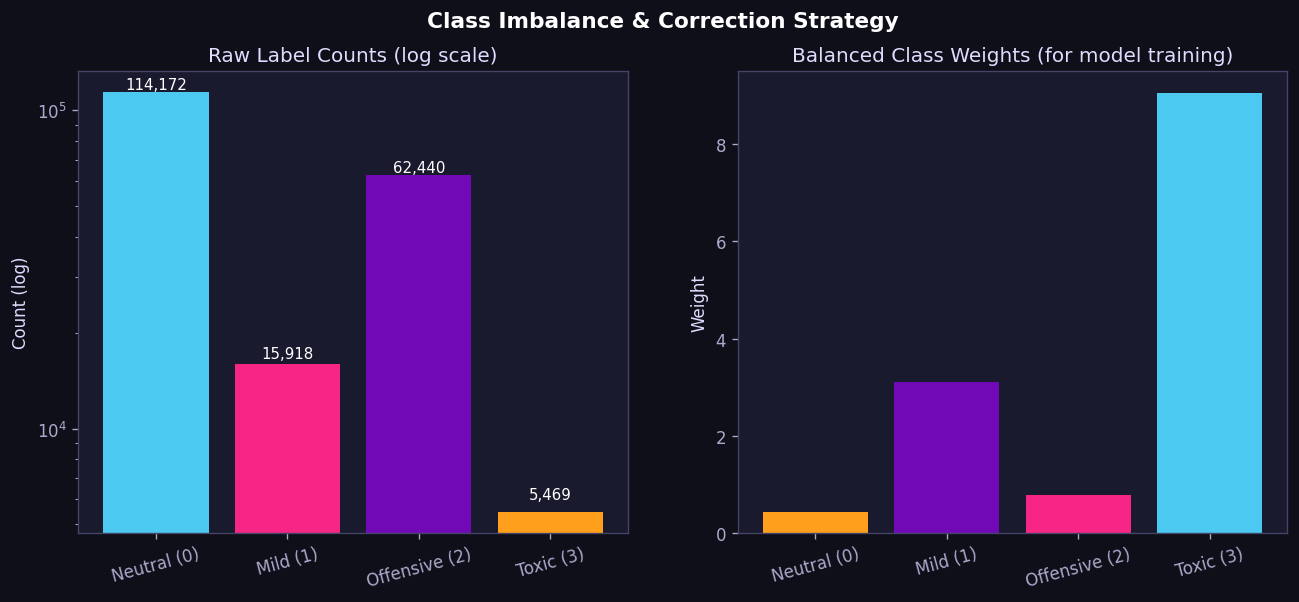

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Class Imbalance & Correction Strategy', fontsize=13, color='white', fontweight='bold')

ax = axes[0]
bars = ax.bar([LABEL_NAMES[i] for i in lbl_counts.index], lbl_counts.values, color=PALETTE)
for bar, cnt in zip(bars, lbl_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 400,
            f'{cnt:,}', ha='center', va='bottom', fontsize=9, color='white')
ax.set_yscale('log')
ax.set_title('Raw Label Counts (log scale)'); ax.set_ylabel('Count (log)')
ax.tick_params(axis='x', rotation=15)

ax = axes[1]
ax.bar([LABEL_NAMES[i] for i in sorted(class_weight_dict)],
       [class_weight_dict[i] for i in sorted(class_weight_dict)], color=PALETTE[::-1])
ax.set_title('Balanced Class Weights (for model training)')
ax.set_ylabel('Weight'); ax.tick_params(axis='x', rotation=15)

Strategies to handle imbalance:
  1. class_weight_dict  → pass to sklearn (LogReg, RF …) and XGBoost
  2. SMOTE (imblearn)   → oversample inside each CV fold (never before splitting)
  3. ADASYN (imblearn)  → adaptive synthetic sampling, useful for label 1 & 3

## 8. TF-IDF Vectorisation

In [19]:
# ── TF-IDF on fully cleaned text (unigrams + bigrams) ─────────────────────────
# sublinear_tf=True → log(1+tf), reduces influence of very frequent terms
# min_df=3          → ignore tokens seen in < 3 documents (likely typos/noise)
# max_df=0.95       → ignore tokens in > 95 % of docs (too common to discriminate)

tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=50_000,
    sublinear_tf=True,
    min_df=3,
    max_df=0.95,
    strip_accents='unicode',
    analyzer='word',
)
X_tfidf_word_train = tfidf_word.fit_transform(df_train['comment_clean'])
X_tfidf_word_test  = tfidf_word.transform(df_test['comment_clean'])

print(f'Word TF-IDF — train: {X_tfidf_word_train.shape}  |  test: {X_tfidf_word_test.shape}')
print(f'Vocabulary size: {len(tfidf_word.vocabulary_):,}')

Word TF-IDF — train: (197999, 50000)  |  test: (102000, 50000)
Vocabulary size: 50,000


In [20]:
# ── Character-level TF-IDF (3–5 grams) — captures morphological patterns ──────
# Useful for detecting obfuscated toxic words (e.g. "st*pid", "h8te")
tfidf_char = TfidfVectorizer(
    ngram_range=(3, 5),
    max_features=30_000,
    sublinear_tf=True,
    min_df=5,
    max_df=0.95,
    strip_accents='unicode',
    analyzer='char_wb',   # char_wb: pads with spaces at word boundaries
)
X_tfidf_char_train = tfidf_char.fit_transform(df_train['comment_light'])
X_tfidf_char_test  = tfidf_char.transform(df_test['comment_light'])

print(f'Char TF-IDF  — train: {X_tfidf_char_train.shape}  |  test: {X_tfidf_char_test.shape}')

Char TF-IDF  — train: (197999, 30000)  |  test: (102000, 30000)


In [21]:
# ── Inspect top TF-IDF terms per label (word-level) ───────────────────────────
vocab = np.array(tfidf_word.get_feature_names_out())
print('Top-15 word TF-IDF terms per label (mean weight):')
for lbl in sorted(np.unique(y_train)):
    mask   = y_train == lbl
    # mean over only the rows of that class
    means  = np.asarray(X_tfidf_word_train[mask].mean(axis=0)).flatten()
    top15  = vocab[np.argsort(means)[::-1][:15]].tolist()
    print(f'  Label {lbl} ({LABEL_NAMES[lbl]}): {top15}')

Top-15 word TF-IDF terms per label (mean weight):
  Label 0 (Neutral (0)): ['one', 'like', 'people', 'trump', 'time', 'year', 'think', 'good', 'know', 'need', 'right', 'work', 'say', 'make', 'real']
  Label 1 (Mild (1)): ['white', 'muslim', 'black', 'people', 'christian', 'gay', 'women', 'like', 'racist', 'right', 'one', 'islam', 'american', 'terrorist', 'trump']
  Label 2 (Offensive (2)): ['trump', 'like', 'people', 'one', 'think', 'right', 'know', 'say', 'real', 'time', 'make', 'need', 'even', 'liberal', 'president']
  Label 3 (Toxic (3)): ['kill', 'shoot', 'death', 'people', 'gun', 'shot', 'lock', 'die', 'dead', 'one', 'head', 'like', 'need', 'time', 'trump']


In [22]:
# ── Combine all features into final sparse matrices ────────────────────────────
X_combined_train = hstack([
    X_tfidf_word_train,
    X_tfidf_char_train,
    csr_matrix(dense_train_scaled)
])
X_combined_test = hstack([
    X_tfidf_word_test,
    X_tfidf_char_test,
    csr_matrix(dense_test_scaled)
])

print(f'Combined matrix — train: {X_combined_train.shape}')
print(f'Combined matrix — test : {X_combined_test.shape}')
print(f'  Word TF-IDF   : {X_tfidf_word_train.shape[1]:>7,} features')
print(f'  Char TF-IDF   : {X_tfidf_char_train.shape[1]:>7,} features')
print(f'  Dense metadata: {dense_train_scaled.shape[1]:>7,} features')

Combined matrix — train: (197999, 80056)
Combined matrix — test : (102000, 80056)
  Word TF-IDF   :  50,000 features
  Char TF-IDF   :  30,000 features
  Dense metadata:      56 features


## 9. Train / Validation Split

In [23]:
# Stratified 80/20 split — preserves class proportions in both folds
X_tr, X_val, y_tr, y_val = train_test_split(
    X_combined_train, y_train,
    test_size=0.20,
    random_state=42,
    stratify=y_train
)

print(f'Train : {X_tr.shape}   |  {len(y_tr):,} labels')
print(f'Val   : {X_val.shape}  |  {len(y_val):,} labels')

# Verify stratification
tr_pct  = pd.Series(y_tr).value_counts(normalize=True).sort_index() * 100
val_pct = pd.Series(y_val).value_counts(normalize=True).sort_index() * 100
check = pd.DataFrame({'Train %': tr_pct, 'Val %': val_pct})
check.index = [LABEL_NAMES[i] for i in check.index]
display(check.round(2))

Train : (158399, 80056)   |  158,399 labels
Val   : (39600, 80056)  |  39,600 labels


,Train %,Val %
Neutral (0),57.66,57.66
Mild (1),8.04,8.04
Offensive (2),31.54,31.54
Toxic (3),2.76,2.76


# Training Model

In [24]:
RESULTS = []  
CLASSES = [0,1,2,3]

def evaluate(name, model, X_tr, y_tr, X_val, y_val, fit=True):
    """Fit (optionally) and evaluate a model; append to RESULTS."""
    t0 = time.time()
    if fit:
        model.fit(X_tr, y_tr)
    elapsed = time.time() - t0
    preds = model.predict(X_val)
    mac_f1 = f1_score(y_val, preds, average='macro')
    wt_f1  = f1_score(y_val, preds, average='weighted')
    acc    = accuracy_score(y_val, preds)
    per_cls= f1_score(y_val, preds, average=None, labels=CLASSES)
    RESULTS.append({
        'Model': name,
        'Macro-F1': round(mac_f1, 4),
        'Weighted-F1': round(wt_f1, 4),
        'Accuracy': round(acc, 4),
        'F1-Neutral': round(per_cls[0], 4),
        'F1-Mild':    round(per_cls[1], 4),
        'F1-Offens.': round(per_cls[2], 4),
        'F1-Toxic':   round(per_cls[3], 4),
        'Train-s': round(elapsed, 1),
    })
    print(f'  [{name:35s}]  Macro-F1={mac_f1:.4f}  Acc={acc:.4f}  ({elapsed:.1f}s)')
    return model


def plot_confusion(name, model, X_val, y_val):
    preds = model.predict(X_val)
    cm    = confusion_matrix(y_val, preds, labels=CLASSES)
    fig, ax = plt.subplots(figsize=(6,5))
    disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[c] for c in CLASSES])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'Confusion Matrix — {name}', fontsize=10)
    plt.tight_layout(); plt.show()


def leaderboard():
    df = pd.DataFrame(RESULTS).sort_values('Macro-F1', ascending=False).reset_index(drop=True)
    df.index += 1
    return df

print('Evaluation helpers ready.')

Evaluation helpers ready.


## 3.1 Dummy Baseline Classifier

In [59]:
# Stratified dummy — random predictions proportional to class frequency
dum_strat = evaluate('Dummy (stratified)',
    DummyClassifier(strategy='stratified', random_state=42),
    X_tr, y_tr, X_val, y_val)

# Most-frequent dummy
dum_freq = evaluate('Dummy (most_frequent)',
    DummyClassifier(strategy='most_frequent'),
    X_tr, y_tr, X_val, y_val)

  [Dummy (stratified)                 ]  Macro-F1=0.2529  Acc=0.4427  (0.0s)
  [Dummy (most_frequent)              ]  Macro-F1=0.1829  Acc=0.5766  (0.0s)


## 3.2 Logistic Regression

In [60]:
lr = evaluate('Logistic Regression (saga, C=1)',
    LogisticRegression(
        C=1.0, solver='saga', max_iter=1000,
        class_weight='balanced',
        random_state=42, n_jobs=-1,
    ),
    X_tr, y_tr, X_val, y_val)

  [Logistic Regression (saga, C=1)    ]  Macro-F1=0.7956  Acc=0.8958  (2960.8s)


## 3.3 SGD Classifier (3 loss variants)

In [61]:
for loss in ['log_loss', 'modified_huber', 'hinge']:
    evaluate(f'SGD ({loss})',
        SGDClassifier(loss=loss, max_iter=200, class_weight='balanced',
                      n_jobs=-1, random_state=42),
        X_tr, y_tr, X_val, y_val)

  [SGD (log_loss)                     ]  Macro-F1=0.7834  Acc=0.8944  (20.2s)
  [SGD (modified_huber)               ]  Macro-F1=0.7625  Acc=0.8835  (64.4s)
  [SGD (hinge)                        ]  Macro-F1=0.7800  Acc=0.8931  (15.1s)


## 3.4 Passive Aggressive Classifier

In [62]:
evaluate('Passive Aggressive',
    PassiveAggressiveClassifier(max_iter=200, class_weight='balanced', random_state=42),
    X_tr, y_tr, X_val, y_val)

  [Passive Aggressive                 ]  Macro-F1=0.7740  Acc=0.8884  (101.6s)


PassiveAggressiveClassifier(class_weight='balanced', max_iter=200,
                            random_state=42)

## 3.5 Ridge Classifier

In [63]:
evaluate('Ridge Classifier',
    RidgeClassifier(class_weight='balanced'),
    X_tr, y_tr, X_val, y_val)

  [Ridge Classifier                   ]  Macro-F1=0.7897  Acc=0.8953  (633.0s)


RidgeClassifier(class_weight='balanced')

## 3.6 Naive Bayes Variants

> NB models require non-negative input. We use only the TF-IDF portion of the matrix 
(first 80,000 columns = word 50k + char 30k), which is always ≥ 0.


In [64]:
# TF-IDF portion only (word 50k + char 30k = 80k cols) — all non-negative
TFIDF_COLS = 80_000   # word(50k) + char(30k)
X_tr_nb  = X_tr[:, :TFIDF_COLS]
X_val_nb = X_val[:, :TFIDF_COLS]

evaluate('Complement NB',
    ComplementNB(alpha=0.1),
    X_tr_nb, y_tr, X_val_nb, y_val)

evaluate('Multinomial NB',
    MultinomialNB(alpha=0.1),
    X_tr_nb, y_tr, X_val_nb, y_val)

# BernoulliNB — binarise TF-IDF
evaluate('Bernoulli NB',
    BernoulliNB(alpha=0.5),
    X_tr_nb, y_tr, X_val_nb, y_val)

  [Complement NB                      ]  Macro-F1=0.6202  Acc=0.7100  (0.5s)
  [Multinomial NB                     ]  Macro-F1=0.6335  Acc=0.7317  (0.6s)
  [Bernoulli NB                       ]  Macro-F1=0.3772  Acc=0.3841  (1.2s)


BernoulliNB(alpha=0.5)

## 3.7 Linear SVC

In [65]:
# Calibrated so we can get probability estimates for Stacking later
lsvc_base = LinearSVC(C=0.5, class_weight='balanced', max_iter=2000, random_state=42)
lsvc = evaluate('LinearSVC (C=0.5)',
    CalibratedClassifierCV(lsvc_base, cv=3),
    X_tr, y_tr, X_val, y_val)

  [LinearSVC (C=0.5)                  ]  Macro-F1=0.8173  Acc=0.9139  (1917.8s)


## 3.8 K-Nearest Neighbors

> KNN on 50k-row subsample (high-dim sparse KNN is O(n·m) — impractical at full scale).

In [66]:
SUB = 50_000
rng = np.random.default_rng(42)
idx = rng.choice(X_tr.shape[0], size=min(SUB, X_tr.shape[0]), replace=False)
X_knn_tr, y_knn_tr = X_tr[idx], y_tr[idx]

for k in [5, 11]:
    evaluate(f'KNN (k={k}, subsample)',
        KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1),
        X_knn_tr, y_knn_tr, X_val, y_val)

  [KNN (k=5, subsample)               ]  Macro-F1=0.5638  Acc=0.8098  (0.2s)
  [KNN (k=11, subsample)              ]  Macro-F1=0.5765  Acc=0.8276  (0.2s)


## 3.9 Decision Tree

In [67]:
evaluate('Decision Tree (md=20)',
    DecisionTreeClassifier(max_depth=20, class_weight='balanced', random_state=42),
    X_tr, y_tr, X_val, y_val)

  [Decision Tree (md=20)              ]  Macro-F1=0.6999  Acc=0.8603  (719.6s)


DecisionTreeClassifier(class_weight='balanced', max_depth=20, random_state=42)

## 3.10 Random Forest

In [68]:
evaluate('Random Forest (n=200)',
    RandomForestClassifier(n_estimators=200, max_depth=30,
                           class_weight='balanced', n_jobs=-1, random_state=42),
    X_tr, y_tr, X_val, y_val)

  [Random Forest (n=200)              ]  Macro-F1=0.7324  Acc=0.8610  (360.0s)


RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=200,
                       n_jobs=-1, random_state=42)

## 3.11 Extra Trees

In [69]:
evaluate('Extra Trees (n=200)',
    ExtraTreesClassifier(n_estimators=200, max_depth=30,
                         class_weight='balanced', n_jobs=-1, random_state=42),
    X_tr, y_tr, X_val, y_val)

  [Extra Trees (n=200)                ]  Macro-F1=0.6395  Acc=0.7574  (249.7s)


ExtraTreesClassifier(class_weight='balanced', max_depth=30, n_estimators=200,
                     n_jobs=-1, random_state=42)

## 3.12 XGBoost

In [73]:
classes = np.unique(y_tr)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_tr
)

class_weight_dict = dict(zip(classes, class_weights))

sw_tr = np.array([class_weight_dict[y] for y in y_tr])

dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sw_tr)
dval   = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'multi:softprob',
    'num_class': len(CLASSES),
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'seed': 42,
}

t0 = time.time()
booster = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dval, 'val')],
    early_stopping_rounds=40,
    verbose_eval=False
)
elapsed = time.time() - t0

# Predict
probs = booster.predict(dval)
preds = probs.argmax(axis=1)

# Metrics
mac_f1 = f1_score(y_val, preds, average='macro')
wt_f1  = f1_score(y_val, preds, average='weighted')
acc    = accuracy_score(y_val, preds)
per    = f1_score(y_val, preds, average=None, labels=CLASSES)

print(f'[XGBoost-native] Macro-F1={mac_f1:.4f}  Acc={acc:.4f}  ({elapsed:.1f}s)')

[XGBoost-native] Macro-F1=0.7880  Acc=0.8986  (4160.0s)


## 3.13 LightGBM

In [75]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=50,
    lambda_l2=1.0,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)
t0 = time.time()
lgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(40, verbose=False)]
)
elapsed = time.time() - t0
preds   = lgb_model.predict(X_val)

mac_f1 = f1_score(y_val, preds, average='macro')
wt_f1  = f1_score(y_val, preds, average='weighted')
acc    = accuracy_score(y_val, preds)
per    = f1_score(y_val, preds, average=None, labels=CLASSES)
RESULTS.append({'Model':'LightGBM','Macro-F1':round(mac_f1,4),
    'Weighted-F1':round(wt_f1,4),'Accuracy':round(acc,4),
    'F1-Neutral':round(per[0],4),'F1-Mild':round(per[1],4),
    'F1-Offens.':round(per[2],4),'F1-Toxic':round(per[3],4),
    'Train-s':round(elapsed,1)})

print(f'  [LightGBM]  Macro-F1={mac_f1:.4f}  Acc={acc:.4f}  ({elapsed:.1f}s)')

  [LightGBM]  Macro-F1=0.7867  Acc=0.8977  (1990.5s)


# 4. Leaderboard & Top-3 Selection

In [76]:
lb = leaderboard()
print('=== Full Model Leaderboard (sorted by Macro-F1) ===')
display(lb)

TOP3 = lb['Model'].iloc[:3].tolist()
print(f'\n Top-3 models: {TOP3}')

=== Full Model Leaderboard (sorted by Macro-F1) ===


,Model,Macro-F1,Weighted-F1,Accuracy,F1-Neutral,F1-Mild,F1-Offens.,F1-Toxic,Train-s
1,LinearSVC (C=0.5),0.8173,0.9133,0.9139,0.9595,0.7800,0.8865,0.6433,1917.8
2,"Logistic Regression (saga, C=1)",0.7956,0.9010,0.8958,0.9542,0.7677,0.8644,0.5963,2960.8
3,Ridge Classifier,0.7897,0.8992,0.8953,0.9528,0.7508,0.8663,0.5890,633.0
4,LightGBM,0.7867,0.9032,0.8977,0.9616,0.7675,0.8612,0.5564,1990.5
5,SGD (log_loss),0.7834,0.8962,0.8944,0.9554,0.7529,0.8529,0.5726,20.2
6,SGD (hinge),0.7800,0.8962,0.8931,0.9562,0.7589,0.8516,0.5531,15.1
7,Passive Aggressive,0.7740,0.8900,0.8884,0.9448,0.7315,0.8591,0.5607,101.6
8,SGD (modified_huber),0.7625,0.8867,0.8835,0.9457,0.7574,0.8455,0.5015,64.4
9,Random Forest (n=200),0.7324,0.8673,0.8610,0.9330,0.7188,0.8209,0.4568,360.0
10,Decision Tree (md=20),0.6999,0.8691,0.8603,0.9562,0.7017,0.7986,0.3432,719.6



 Top-3 models: ['LinearSVC (C=0.5)', 'Logistic Regression (saga, C=1)', 'Ridge Classifier']


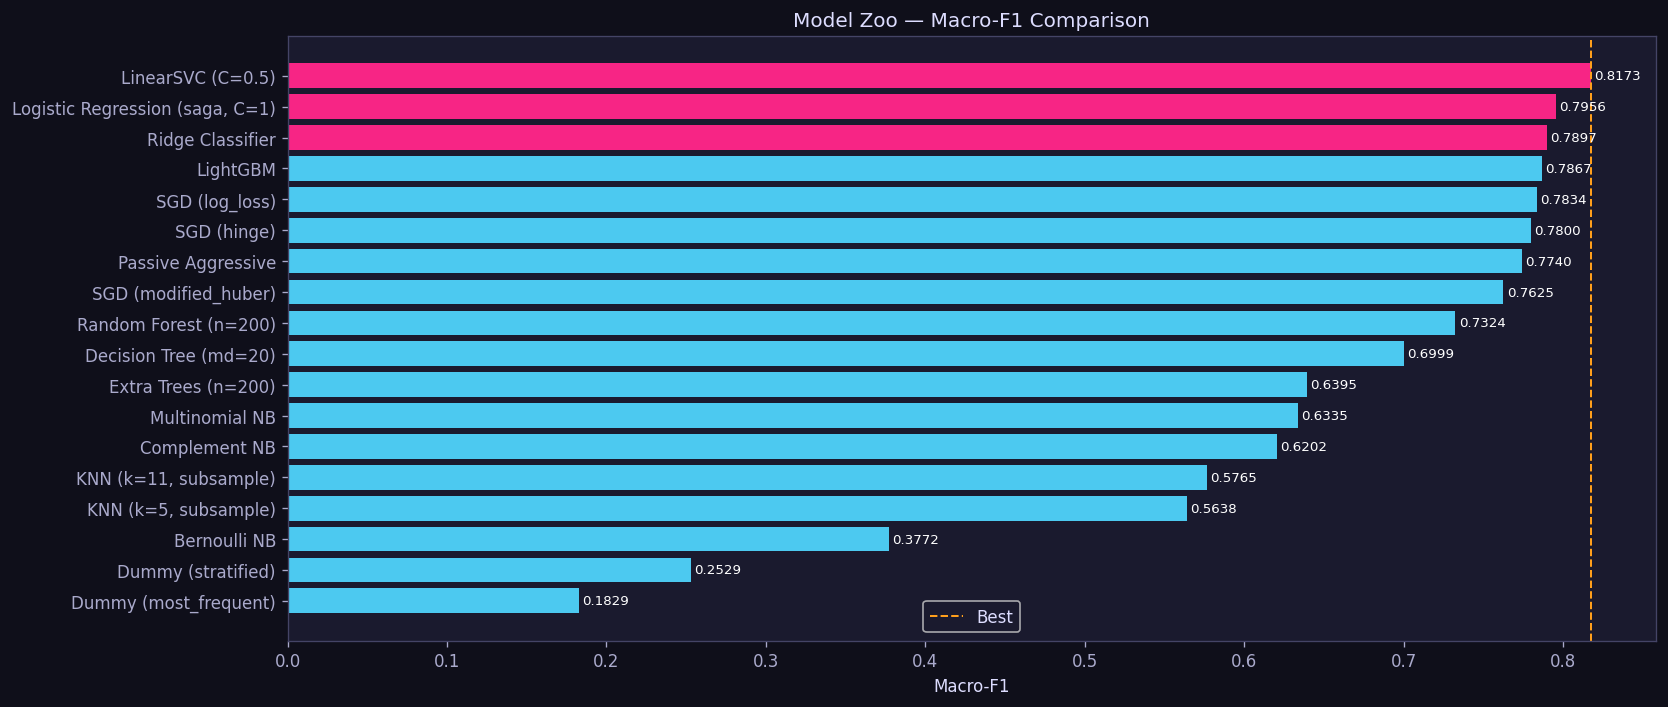

In [77]:
# ── Bar chart — Macro-F1 per model ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['#f72585' if m in TOP3 else '#4cc9f0' for m in lb['Model']]
bars = ax.barh(lb['Model'], lb['Macro-F1'], color=colors, edgecolor='none')
for bar, val in zip(bars, lb['Macro-F1']):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=8, color='white')
ax.set_xlabel('Macro-F1')
ax.set_title('Model Zoo — Macro-F1 Comparison')
ax.invert_yaxis()
ax.axvline(lb['Macro-F1'].max(), color='#ff9f1c', linewidth=1.2, linestyle='--', label='Best')
ax.legend()
plt.tight_layout(); plt.show()

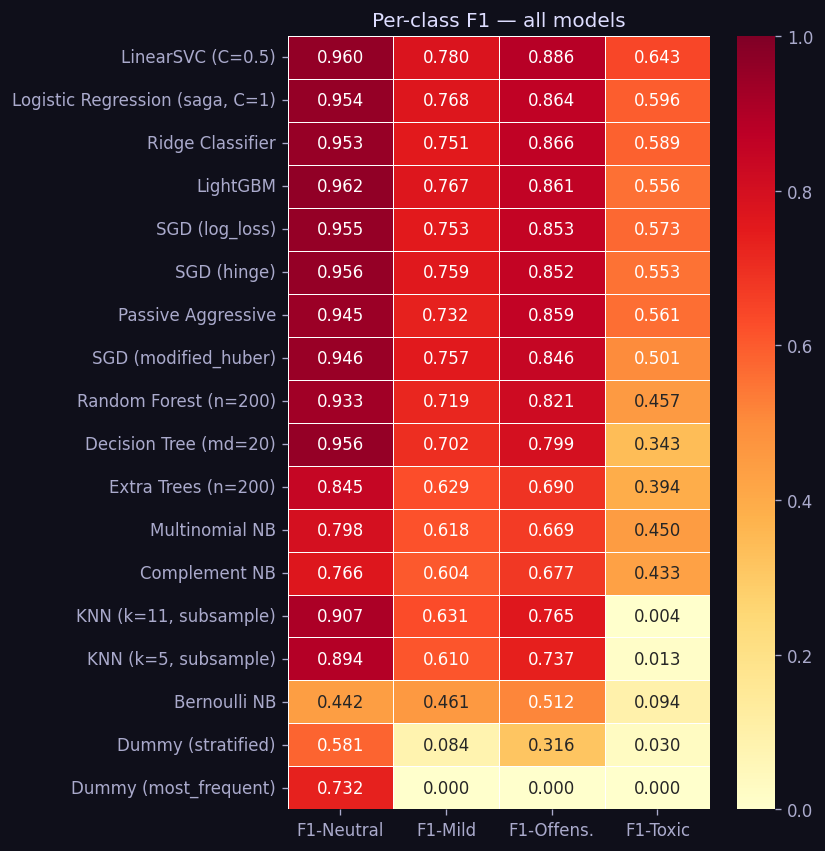

In [78]:
# ── Per-class F1 heatmap ─────────────────────────────────────────────────────
cls_cols = ['F1-Neutral','F1-Mild','F1-Offens.','F1-Toxic']
heat     = lb.set_index('Model')[cls_cols]
fig, ax  = plt.subplots(figsize=(7, max(5, len(heat)*0.4)))
sns.heatmap(heat.astype(float), annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.3, ax=ax, vmin=0, vmax=1)
ax.set_title('Per-class F1 — all models'); ax.set_ylabel('')
plt.tight_layout(); plt.show()

# 5. Ensemble Methods

Using Logistic Regression as the base for Bagging (good sparse-matrix support).  
Top-2 + LightGBM form the Voting/Stacking line-up.

## 5.1 Bagging (base = Logistic Regression)

In [80]:
BaggingClassifier(
    estimator=base_lr,
    n_estimators=5,      # not 15
    max_samples=0.6,     # less data
    n_jobs=2,            # don't nuke the CPU
    random_state=42
)
evaluate('Bagging (LR, n=15)',
    BaggingClassifier(estimator=base_lr, n_estimators=15,
                      max_samples=0.8, n_jobs=-1, random_state=42),
    X_tr, y_tr, X_val, y_val)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

  [Bagging (LR, n=15)                 ]  Macro-F1=0.7910  Acc=0.8925  (10470.8s)


BaggingClassifier(estimator=LogisticRegression(class_weight='balanced',
                                               max_iter=500,
                                               multi_class='multinomial',
                                               n_jobs=1, random_state=42,
                                               solver='saga'),
                  max_samples=0.8, n_estimators=15, n_jobs=-1, random_state=42)

## 5.2 AdaBoost

In [25]:
# Uses Decision Tree stumps by default
evaluate('AdaBoost (n=200, lr=0.5)',
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=200, learning_rate=0.5,
        algorithm='SAMME', random_state=42,
    ),
    X_tr, y_tr, X_val, y_val)

  [AdaBoost (n=200, lr=0.5)           ]  Macro-F1=0.7159  Acc=0.8896  (13890.6s)


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=200, random_state=42)

## 5.3 Voting Classifier (hard & soft)

In [ ]:
# Estimators: LR + LightGBM + LinearSVC (calibrated)
_lr   = LogisticRegression(C=1.0, solver='saga', max_iter=500,
                           class_weight='balanced', n_jobs=1, random_state=42)
_lgb  = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05,
                            class_weight='balanced', n_jobs=-1, verbose=-1, random_state=42)
_svc  = CalibratedClassifierCV(
    LinearSVC(C=0.5, class_weight='balanced', max_iter=1000, random_state=42), cv=3)

vote_hard = evaluate('Voting — hard (LR+LGBM+SVC)',
    VotingClassifier([('lr',_lr),('lgbm',_lgb),('svc',_svc)],
                     voting='hard', n_jobs=-1),
    X_tr, y_tr, X_val, y_val)

vote_soft = evaluate('Voting — soft (LR+LGBM+SVC)',
    VotingClassifier([('lr',_lr),('lgbm',_lgb),('svc',_svc)],
                     voting='soft', n_jobs=-1),
    X_tr, y_tr, X_val, y_val)

## 5.4 Stacking Classifier

In [ ]:
# Level-0: LR + LGBM + LinearSVC(calibrated)
# Level-1 (meta): Logistic Regression
_lr_s  = LogisticRegression(C=1.0, solver='saga', max_iter=300,
                            class_weight='balanced', n_jobs=1, random_state=42)
_lgb_s = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05,
                             class_weight='balanced', n_jobs=-1, verbose=-1, random_state=42)
_svc_s = CalibratedClassifierCV(
    LinearSVC(C=0.5, class_weight='balanced', max_iter=1000, random_state=42), cv=3)

meta = LogisticRegression(C=2.0, solver='saga', max_iter=300,
                          class_weight='balanced', n_jobs=1, random_state=42)

evaluate('Stacking (LR+LGBM+SVC → LR)',
    StackingClassifier(
        estimators=[('lr',_lr_s),('lgbm',_lgb_s),('svc',_svc_s)],
        final_estimator=meta,
        cv=3, passthrough=False, n_jobs=-1,
    ),
    X_tr, y_tr, X_val, y_val)

# 6. MultiLayer Perceptron (MLPClassifier)

In [ ]:
# Dense input only (MLP on 80k-dim sparse is very slow);
# use the scaled dense feature matrix.
import pickle
with open(f'{PRE}/scaler.pkl','rb') as fh:
    scaler = pickle.load(fh)
with open(f'{PRE}/dense_feature_names.pkl','rb') as fh:
    dense_cols = pickle.load(fh)

n_dense = len(dense_cols)
# Dense features sit at the END of the combined matrix
X_tr_dense  = X_tr[:, -n_dense:].toarray()
X_val_dense = X_val[:, -n_dense:].toarray()

evaluate('MLP (128-64, dense feats)',
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu', solver='adam',
        alpha=1e-4, batch_size=256,
        learning_rate_init=1e-3, max_iter=50,
        early_stopping=True, validation_fraction=0.1,
        random_state=42,
    ),
    X_tr_dense, y_tr, X_val_dense, y_val)

In [ ]:
# Larger MLP on full sparse (sub-sampled 100k for speed)
from sklearn.preprocessing import MaxAbsScaler
SUB2 = 100_000
rng2 = np.random.default_rng(0)
idx2 = rng2.choice(X_tr.shape[0], size=min(SUB2, X_tr.shape[0]), replace=False)
Xs_tr  = MaxAbsScaler().fit_transform(X_tr[idx2])
Xs_val = MaxAbsScaler().fit_transform(X_val)

evaluate('MLP (256-128-64, TF-IDF sub)',
    MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu', solver='adam',
        alpha=1e-4, batch_size=512,
        learning_rate_init=1e-3, max_iter=30,
        early_stopping=True, validation_fraction=0.1,
        random_state=42,
    ),
    Xs_tr, y_tr[idx2], Xs_val, y_val)

# 7. Updated Full Leaderboard

In [ ]:
lb2 = leaderboard()
display(lb2)
BEST_MODEL_NAME = lb2['Model'].iloc[0]
print(f'\n Best model overall: {BEST_MODEL_NAME}')


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Final Leaderboard Summary', fontsize=13, color='white', fontweight='bold')

# Macro-F1 bar
ax = axes[0]
top_n = min(15, len(lb2))
sub   = lb2.head(top_n)
colors2 = ['#f72585' if i == 0 else '#4cc9f0' for i in range(top_n)]
ax.barh(sub['Model'], sub['Macro-F1'], color=colors2)
ax.invert_yaxis()
ax.set_xlabel('Macro-F1'); ax.set_title('Top Models by Macro-F1')

# Per-class heatmap
ax = axes[1]
heat2 = lb2.set_index('Model')[cls_cols].head(top_n).astype(float)
sns.heatmap(heat2, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.3, ax=ax, vmin=0, vmax=1)
ax.set_title('Per-class F1 (top models)'); ax.set_ylabel('')

plt.tight_layout(); plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ── Search grids for candidate best models ────────────────────────────────────
SEARCH_CONFIGS = {
    'LightGBM': {
        'estimator': lgb.LGBMClassifier(
            class_weight='balanced', n_jobs=-1,
            verbose=-1, random_state=42,
        ),
        'param_distributions': {
            'n_estimators':    randint(200, 1000),
            'learning_rate':   uniform(0.01, 0.14),
            'max_depth':       randint(4, 12),
            'num_leaves':      randint(20, 150),
            'subsample':       uniform(0.6, 0.4),
            'colsample_bytree':uniform(0.5, 0.5),
            'reg_alpha':       uniform(0, 1.0),
            'reg_lambda':      uniform(0, 1.0),
            'min_child_samples': randint(10, 100),
        },
    },
    'XGBoost': {
        'estimator': xgb.XGBClassifier(
            use_label_encoder=False, eval_metric='mlogloss',
            tree_method='hist', device='cpu',
            random_state=42, n_jobs=-1,
        ),
        'param_distributions': {
            'n_estimators':    randint(200, 800),
            'learning_rate':   uniform(0.01, 0.14),
            'max_depth':       randint(4, 10),
            'subsample':       uniform(0.6, 0.4),
            'colsample_bytree':uniform(0.5, 0.5),
            'gamma':           uniform(0, 0.5),
            'min_child_weight':randint(1, 20),
            'reg_alpha':       uniform(0, 1.0),
            'reg_lambda':      uniform(0, 2.0),
        },
    },
    'Logistic Regression (saga, C=1)': {
        'estimator': LogisticRegression(
            solver='saga', max_iter=1000,
            class_weight='balanced', multi_class='multinomial',
            random_state=42, n_jobs=-1,
        ),
        'param_distributions': {
            'C':    uniform(0.01, 10.0),
            'l1_ratio': uniform(0, 1),   # only used if penalty='elasticnet'
            'penalty': ['l2', 'l1'],
        },
    },
}

# Pick the right config
def _get_config(best_name):
    for key in SEARCH_CONFIGS:
        if key.lower() in best_name.lower() or best_name.lower() in key.lower():
            return SEARCH_CONFIGS[key]
    # fallback: LightGBM
    return SEARCH_CONFIGS['LightGBM']

config = _get_config(BEST_MODEL_NAME)
print(f'Running RandomizedSearchCV for: {BEST_MODEL_NAME}')
print(f'Search space size: {len(config["param_distributions"])} parameters')

In [ ]:
N_ITER = 30   # increase for more thorough search (at cost of time)

search = RandomizedSearchCV(
    config['estimator'],
    config['param_distributions'],
    n_iter=N_ITER,
    scoring='f1_macro',
    cv=CV,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

sw_full = np.array([CW[y] for y in y_full])

# Fit on full training data (train+val combined) for final model
print('Fitting on full training set...')
t0 = time.time()
# XGBoost needs sample_weight; others use class_weight
fit_params = {}
if 'xgb' in BEST_MODEL_NAME.lower() or 'xgboost' in BEST_MODEL_NAME.lower():
    fit_params['sample_weight'] = sw_full
search.fit(X_full, y_full, **fit_params)
print(f'Search complete in {time.time()-t0:.0f}s')
print(f'Best Macro-F1 (CV): {search.best_score_:.4f}')
print(f'Best params:\n{search.best_params_}')

In [ ]:
# ── Evaluate tuned model on held-out val set ──────────────────────────────────
best_model = search.best_estimator_
preds_tuned = best_model.predict(X_val)

print('=== Tuned Model — Classification Report ===')
print(classification_report(
    y_val, preds_tuned,
    target_names=[LABEL_NAMES[c] for c in CLASSES],
))

mac_f1_tuned = f1_score(y_val, preds_tuned, average='macro')
print(f'Tuned Macro-F1 on val: {mac_f1_tuned:.4f}')

plot_confusion(f'{BEST_MODEL_NAME} (tuned)', best_model, X_val, y_val)

In [ ]:
# ── CV learning curves ────────────────────────────────────────────────────────
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values('rank_test_score').head(20)

fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(
    range(len(results_df)),
    results_df['mean_test_score'],
    yerr=results_df['std_test_score'],
    fmt='o-', color='#4cc9f0', ecolor='#7209b7', capsize=3,
)
ax.set_xlabel('Top-20 parameter combinations (ranked)')
ax.set_ylabel('CV Macro-F1 (mean ± std)')
ax.set_title(f'RandomizedSearchCV Results — {BEST_MODEL_NAME}')
plt.tight_layout(); plt.show()

In [ ]:
test   = pd.read_csv("/kaggle/input/comment-category-prediction-challenge/test.csv")

# Predict
test_preds = best_model.predict(X_combined_test)

# Build submission
submission = pd.DataFrame({
    "ID":    range(1, len(test) + 1),
    "label": test_preds
})
assert len(submission) == len(test), "❌ Row count mismatch!"
submission.to_csv("submission.csv", index=False)

print(f"\n✅  submission.csv saved  ({len(submission)} rows)")
print(f"   Label distribution:\n{submission['label'].value_counts().to_string()}")